## 0.1 Imports

In [148]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from sqlalchemy              import create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestRegressor
from boruta                  import BorutaPy
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import OneHotEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn.preprocessing   import LabelEncoder
from sklearn.preprocessing   import OneHotEncoder
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics          import mean_absolute_error, mean_squared_error



## 0.2 Configurando conexão com SQLite 

In [2]:
engine = create_engine("sqlite://///Users/jonatas/Documents/db_paipe/Untitled")

## 0.3 Carregando dados de TREINO e dados de TESTE do BD

In [3]:
# Dados de treino
df = pd.read_sql("SELECT * FROM traindf", con=engine)

df_treino = df.copy()
# Dados de teste
#df_teste = pd.read_sql("SELECT * FROM test", con=engine)

## 1.0 Overview, Limpeza e Análise Exploratória de Dados

In [4]:
df_treino.head()

,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,...,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks,TradePrice
0,Pre-owned Condominiums,etc.,13103,Tokyo,Minato Ward,Kaigan,Takeshiba,1,1.0,1.0,...,,Quasi-industrial Zone,60.0,400.0,1st quarter 2011,2011,1,Done,,24000000
1,Residential Land(Land and Building),Residential Area,13120,Tokyo,Nerima Ward,Nishiki,Kamiitabashi,15,15.0,15.0,...,4.0,Category I Exclusively Low-story Residential Zone,60.0,200.0,3rd quarter 2013,2013,3,,Dealings including private road,51000000
2,Residential Land(Land Only),Residential Area,13201,Tokyo,Hachioji City,Shimoongatamachi,Takao (Tokyo),1H-1H30,60.0,90.0,...,4.5,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2007,2007,4,,,14000000
3,Pre-owned Condominiums,etc.,13208,Tokyo,Chofu City,Kamiishiwara,Nishichofu,16,16.0,16.0,...,,Quasi-industrial Zone,60.0,200.0,2nd quarter 2015,2015,2,Not yet,,23000000
4,Residential Land(Land Only),Residential Area,13117,Tokyo,Kita Ward,Shimo,Shimo,6,6.0,6.0,...,4.5,Category I Exclusively Medium-high Residential...,60.0,200.0,4th quarter 2015,2015,4,,,33000000


In [5]:
print("Numero de linhas: {}".format(df_treino.shape[0]))
print("Numero de colunas: {}".format(df_treino.shape[1]))

Numero de linhas: 325260
Numero de colunas: 37


In [6]:
df_treino.duplicated().sum()

2467

In [7]:
df_treino = df_treino.drop_duplicates()

In [8]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322793 entries, 0 to 325259
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Type                         322793 non-null  object
 1   Region                       322793 non-null  object
 2   MunicipalityCode             322793 non-null  int64 
 3   Prefecture                   322793 non-null  object
 4   Municipality                 322793 non-null  object
 5   DistrictName                 322793 non-null  object
 6   NearestStation               322793 non-null  object
 7   TimeToNearestStation         322793 non-null  object
 8   MinTimeToNearestStation      322793 non-null  object
 9   MaxTimeToNearestStation      322793 non-null  object
 10  FloorPlan                    322793 non-null  object
 11  Area                         322793 non-null  int64 
 12  AreaIsGreaterFlag            322793 non-null  int64 
 13  UnitPrice          

In [9]:
df_treino.describe() # para var numericas

,MunicipalityCode,Area,AreaIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,Year,Quarter,TradePrice
count,322793.000000,322793.000000,322793.000000,322793.000000,322793.000000,322793.000000,322793.000000,3.227930e+05
mean,13139.923948,117.783827,0.003600,0.003036,0.000762,2012.600335,2.499528,6.644556e+07
std,46.162175,204.903810,0.059891,0.055016,0.027596,3.900543,1.118705,3.257466e+08
min,13101.000000,10.000000,0.000000,0.000000,0.000000,2005.000000,1.000000,1.000000e+03
25%,13110.000000,50.000000,0.000000,0.000000,0.000000,2009.000000,1.000000,2.200000e+07
50%,13117.000000,70.000000,0.000000,0.000000,0.000000,2013.000000,3.000000,3.500000e+07
75%,13201.000000,115.000000,0.000000,0.000000,0.000000,2016.000000,3.000000,5.400000e+07
max,13421.000000,5000.000000,1.000000,1.000000,1.000000,2019.000000,4.000000,6.100000e+10


### Convertendo as variáveis para os tipos indicados

In [10]:
# dicionário de mapeamento de tipos de dados
tipo_variaveis = {
    "Type": "str",
    "Region": "str",
    "MunicipalityCode": "int",
    "Prefecture": "str",
    "Municipality": "str",
    "DistrictName": "str",
    "NearestStation": "str",
    "TimeToNearestStation": "str",
    "MinTimeToNearestStation": "int",
    "MaxTimeToNearestStation": "int",
    "FloorPlan": "str",
    "Area": "int",
    "AreaIsGreaterFlag": "int",
    "UnitPrice": "float",
    "PricePerTsubo": "float",
    "LandShape": "str",
    "Frontage": "float",
    "FrontageIsGreaterFlag": "bool",
    "TotalFloorArea": "float",
    "TotalFloorAreaIsGreaterFlag": "int",
    "BuildingYear": "int",
    "PrewarBuilding": "int",
    "Structure": "str",
    "Use": "str",
    "Purpose": "str",
    "Direction": "str",
    "Classification": "str",
    "Breadth": "float",
    "CityPlanning": "str",
    "CoverageRatio": "float",
    "FloorAreaRatio": "float",
    "Period": "str",
    "Year": "int",
    "Quarter": "int",
    "Renovation": "str",
    "Remarks": "str",
    "TradePrice": "int"
}

# Aplicar conversões
for coluna, tipo in tipo_variaveis.items():
    try:
        if tipo == "int":
            df_treino[coluna] = pd.to_numeric(df_treino[coluna], errors='coerce').astype("Int64")
        elif tipo == "float":
            df_treino[coluna] = pd.to_numeric(df_treino[coluna], errors='coerce')
        elif tipo == "bool":
            df_treino[coluna] = df_treino[coluna].map({1: True, 0: False, 'True': True, 'False': False}).astype("boolean")
        else:
            df_treino[coluna] = df_treino[coluna].astype("string")
    except KeyError:
        print(f"Coluna '{coluna}' não encontrada no DataFrame")

print(df_treino.dtypes)


Type                           string[python]
Region                         string[python]
MunicipalityCode                        Int64
Prefecture                     string[python]
Municipality                   string[python]
DistrictName                   string[python]
NearestStation                 string[python]
TimeToNearestStation           string[python]
MinTimeToNearestStation                 Int64
MaxTimeToNearestStation                 Int64
FloorPlan                      string[python]
Area                                    Int64
AreaIsGreaterFlag                       Int64
UnitPrice                             float64
PricePerTsubo                         float64
LandShape                      string[python]
Frontage                              float64
FrontageIsGreaterFlag                 boolean
TotalFloorArea                        float64
TotalFloorAreaIsGreaterFlag             Int64
BuildingYear                            Int64
PrewarBuilding                    

### Verificando missing values 

In [11]:
df_treino.isna().sum()

Type                                0
Region                              0
MunicipalityCode                    0
Prefecture                          0
Municipality                        0
DistrictName                        0
NearestStation                      0
TimeToNearestStation                0
MinTimeToNearestStation          8040
MaxTimeToNearestStation          8163
FloorPlan                           0
Area                                0
AreaIsGreaterFlag                   0
UnitPrice                      259264
PricePerTsubo                  259264
LandShape                           0
Frontage                       160776
FrontageIsGreaterFlag          322793
TotalFloorArea                 213868
TotalFloorAreaIsGreaterFlag         0
BuildingYear                    73682
PrewarBuilding                      0
Structure                           0
Use                                 0
Purpose                             0
Direction                           0
Classificati

## Análise Univariada

### Type                                          

In [12]:
# 5 tipo de imóveis diferentes 
df_treino['Type'].value_counts()

Type
Pre-owned Condominiums                 145311
Residential Land(Land and Building)    113540
Residential Land(Land Only)             63529
Forest Land                               337
Agricultural Land                          76
Name: count, dtype: Int64

### Region                              

In [13]:
# existem observaçoes sem classificação aqui. 
# Vou somar estas areas em etc. e nomear para Mixed Areab
df_treino['Region'].value_counts()

Region
Residential Area              157077
 etc.                         145311
Commercial Area                18497
Industrial Area                 1092
                                 413
Potential Residential Area       403
Name: count, dtype: Int64

In [14]:
# substituir valores vazios ("") por "Mixed Area"
df_treino['Region'] = df_treino['Region'].replace("", "Mixed Area")

### MunicipalityCode

In [15]:
df_treino['MunicipalityCode'].nunique()

59

### Prefecture

In [16]:
# todas as observações são tokyo, portanto podemos tirar essa coluna do dataset
df_treino['Prefecture']

0         Tokyo
1         Tokyo
2         Tokyo
3         Tokyo
4         Tokyo
          ...  
325254    Tokyo
325255    Tokyo
325256    Tokyo
325258    Tokyo
325259    Tokyo
Name: Prefecture, Length: 322793, dtype: string

In [17]:
# Dropar a coluna 'Prefecture'
df_treino.drop(columns=['Prefecture'], inplace=True)


### Municipality

In [18]:
# 59 municípios para 59 código únicos! 
df_treino['Municipality'].nunique()

59

### DistrictName

In [19]:
# Existem 1446 distritos únicos no dataset
df_treino['DistrictName'].nunique()

1446

### NearestStation - nome da estação mais próxima dos imóveis

In [20]:
df_treino['NearestStation'].nunique()
df_treino['NearestStation'].value_counts()

NearestStation
Hachioji           3026
Shinkoiwa          2675
Oizumigakuen       2638
Kanamachi          2077
Mitaka             1959
                   ... 
Sakuragaoka           1
Musashikosugi         1
Tachikawakita         1
Urayasu (Chiba)       1
Yurakucho             1
Name: count, Length: 657, dtype: Int64

### TimeToNearestStation

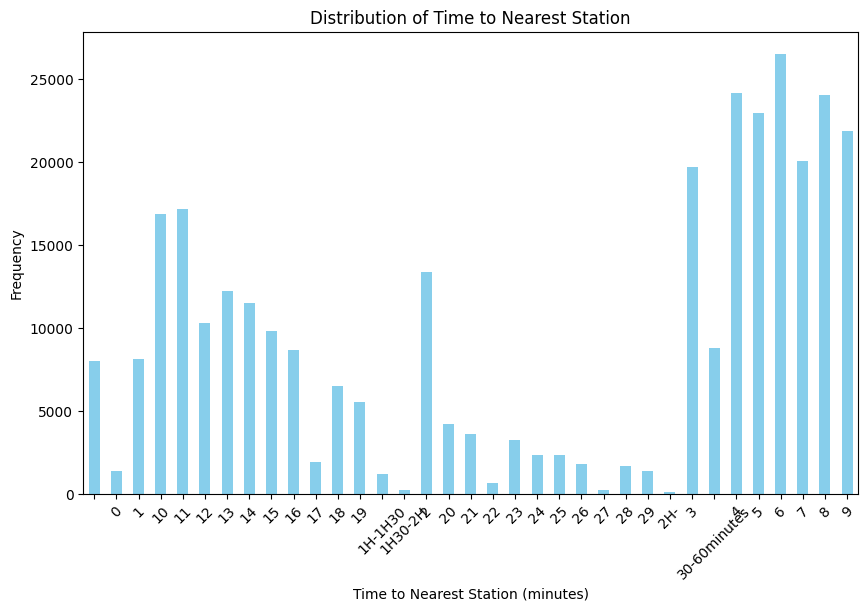

In [21]:
# o tempo mais comum é entre 4 e 9 minutos
time_counts = df_treino['TimeToNearestStation'].value_counts().sort_index()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
time_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Time to Nearest Station (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Time to Nearest Station')
plt.xticks(rotation=45)
plt.show()


### MinTimeToNearestStation & MaxTimeToNearestStation


In [22]:
# para substituir os missing values, vou usar uma média entre o menor MinTimeToNearestStation 
# e o maior MaxTimeToNearestStation para cada município.
municipality_means = df_treino.groupby('Municipality').apply(
    lambda x: (x['MinTimeToNearestStation'].min() + x['MaxTimeToNearestStation'].max()) / 2)

# substitui  os valores nulos usando a média por município
df_treino['MinTimeToNearestStation'] = df_treino.apply(
    lambda row: municipality_means[row['Municipality']] if pd.isnull(row['MinTimeToNearestStation']) else row['MinTimeToNearestStation'],
    axis=1)

df_treino['MaxTimeToNearestStation'] = df_treino.apply(
    lambda row: municipality_means[row['Municipality']] if pd.isnull(row['MaxTimeToNearestStation']) else row['MaxTimeToNearestStation'],
    axis=1)


### FloorPlan - Planta do Imóvel

In [23]:
df_treino['FloorPlan'].nunique()
df_treino['FloorPlan'].value_counts()

FloorPlan
                    182384
3LDK                 39604
1K                   38039
2LDK                 24846
1LDK                 11141
1DK                   7501
2DK                   6479
4LDK                  4227
1R                    2710
3DK                   2179
Open Floor            1272
2LDK+S                 893
2K                     459
1LDK+S                 402
2DK+S                  128
3LDK+S                 119
3K                      94
5LDK                    67
4DK                     59
Studio Apartment        58
4LDK+S                  21
1DK+S                   19
3LK                     14
Duplex                   9
3DK+S                    9
1K+S                     8
1R+S                     7
2K+S                     5
5LDK+S                   4
4K                       4
2LK                      4
1LK                      3
4DK+S                    3
6LDK                     3
1L                       2
2LD+S                    2
3LDK+K            

In [24]:
# aqui temos um problema. uma amostra relevante não tem classificação. 
# como não há indícios para inferir o tipo da planta no imóvel, vou substituir por "Other"
df_treino['FloorPlan'] = df_treino['FloorPlan'].replace("", "Other")

### Area - Área total do imóvel

In [25]:
df_treino[['Area', 'TradePrice']].describe().round(2)
# note que a média é bem diferente da mediana (50%). Ambos valores podem 
# nos dar uma noção de um valor típico da variável. Vamos averiguar o porquê disso.

,Area,TradePrice
count,322793.0,322793.0
mean,117.78,66445562.0
std,204.9,325746552.53
min,10.0,1000.0
25%,50.0,22000000.0
50%,70.0,35000000.0
75%,115.0,54000000.0
max,5000.0,61000000000.0


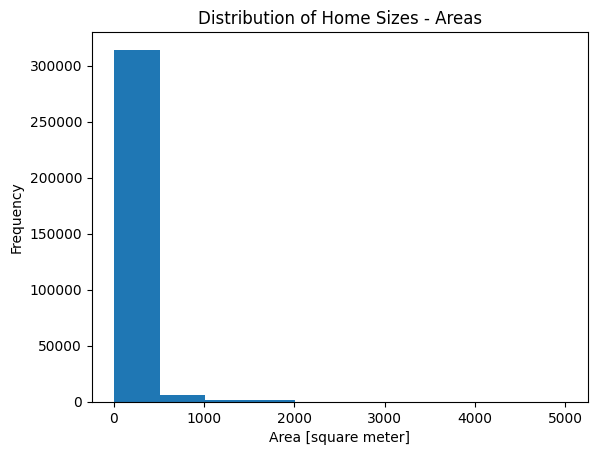

In [26]:
plt.hist(df_treino['Area'])
plt.xlabel('Area [square meter]')
plt.ylabel('Frequency')
plt.title('Distribution of Home Sizes - Areas');

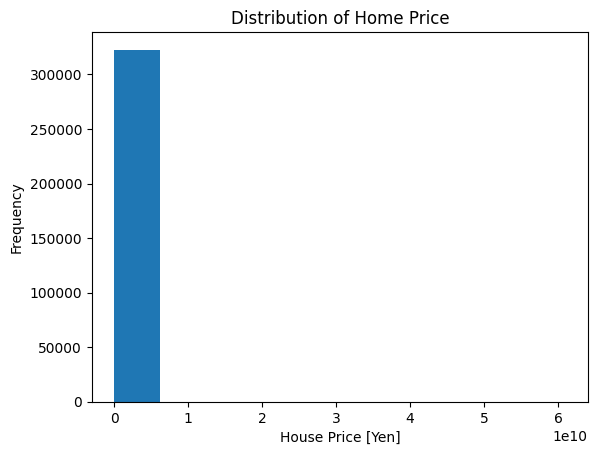

In [27]:
# percebe-se que a distribuição é assimétrica a direita, indicando que a
# maioria das casas são menores (Até 500m2). Menos de 25000 casa tem tamanho 
# de 500m2 - 1000m2. Por isso a diferença na média e mediana

# Histograma para verificar a distribuição do preço das casas
# A distribuição segue assimétrica a direita e a grande maioria das casas 
# estão numa faixa de até 5000000000 Yen
plt.hist(df_treino['TradePrice'])
plt.xlabel('House Price [Yen]')
plt.ylabel('Frequency')
plt.title('Distribution of Home Price');

Text(0, 0.5, 'Área')

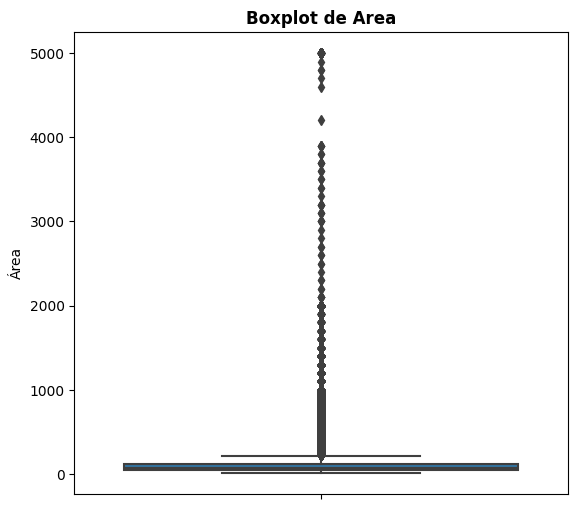

In [28]:
# verificando outliers
plt.figure(figsize=(14, 6))

# Boxplot para a variável 'Area'
plt.subplot(1, 2, 1)
sns.boxplot(data=df_treino, y='Area')
plt.title('Boxplot de Area', fontweight='bold')
plt.ylabel('Área')


In [29]:
# Filtrando areas menores ou iguais a 2000
df_treino = df_treino[df_treino['Area'] <= 2000]


### AreaIsGreaterFlag - Indica se a área é menor/igual a 2000m2

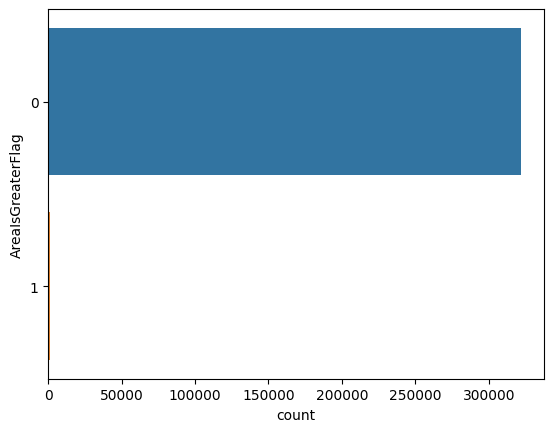

In [30]:
# como vimos anteriormente, a grande maioria das casas tem de 0-500m2
# talvez devemos fazer uma analise para ver se casas que tem acima de 2000m2
# deveriam ser retirados do data set e essa várial ser excluída.
sns.countplot(y='AreaIsGreaterFlag', data = df_treino);

In [31]:
percent_ones = (df_treino['AreaIsGreaterFlag'].sum() / len(df_treino)).round(4)
print(f"A porcentagem do número de imóveis com tamanho > 2000m² é: {percent_ones * 100}%")

A porcentagem do número de imóveis com tamanho > 2000m² é: 0.33%


In [32]:
# vou exlcuir essa variávle uma vez que a amostra de imóveis acuma de 
# 2000m2 é representa 0.33%
df_treino.drop(columns=['AreaIsGreaterFlag'], inplace=True)

### UnitPrice - Preço por unidade de área (Yen/m2) 

In [33]:
# estatística básicas
df_treino['UnitPrice'].describe()

count    6.352900e+04
mean     4.259488e+05
std      4.761644e+05
min      4.000000e+00
25%      2.000000e+05
50%      3.400000e+05
75%      5.400000e+05
max      2.000000e+07
Name: UnitPrice, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


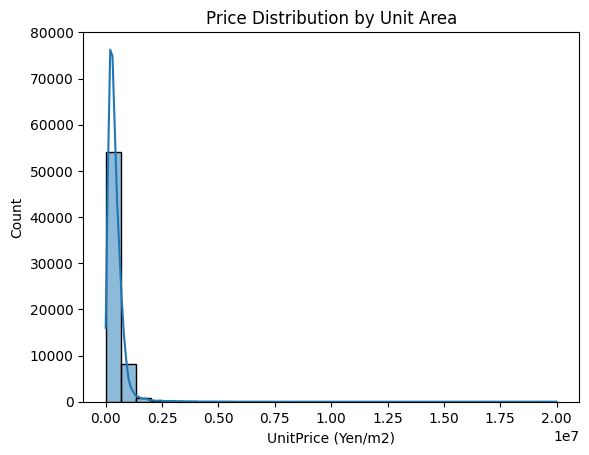

In [34]:
# distribuição do preço da unidade por area
sns.histplot(df_treino['UnitPrice'], bins=30, kde=True);
plt.xlabel("UnitPrice (Yen/m2)")
plt.title("Price Distribution by Unit Area")
plt.show()

Como essa variável possui muitos valores faltantes, vou assumir que pessoas com rendas semelhantes tendem a comprar imóveis com preços por metro quadrado próximos.

Portanto, calcularei a média do valor por metro quadrado para cada município e utilizarei essa média para preencher os valores ausentes em cada município correspondente.

In [35]:
# Calcula a média e a mediana de 'UnitPrice' por 'Municipality'
media_mediana_UnitPrice = df_treino.groupby('Municipality')['UnitPrice'].agg(['mean', 'median'])

print(f"A média do UnitPrice é {df_treino['UnitPrice'].mean()}")
print(f"A mediana do UnitPrice é {df_treino['UnitPrice'].median()}")

# Exibe o resultado
print(media_mediana_UnitPrice)

A média do UnitPrice é 425948.76028270554
A mediana do UnitPrice é 340000.0
                                           mean     median
Municipality                                              
Adachi Ward                        2.625393e+05   240000.0
Akiruno City                       8.953131e+04    90000.0
Akishima City                      1.829932e+05   180000.0
Arakawa Ward                       4.033056e+05   370000.0
Bunkyo Ward                        7.924288e+05   760000.0
Chiyoda Ward                       2.019204e+06  1600000.0
Chofu City                         3.370790e+05   320000.0
Chuo Ward                          2.034217e+06  1300000.0
Edogawa Ward                       3.107808e+05   300000.0
Fuchu City                         2.839057e+05   270000.0
Fussa City                         1.608542e+05   160000.0
Hachijo Town                       6.024014e+03     4450.0
Hachioji City                      1.325487e+05   120000.0
Hamura City                        1.53

In [36]:
df_treino['UnitPrice'] = df_treino.groupby('Municipality')['UnitPrice'].transform(lambda x: x.fillna(x.mean()))

### PricePerTsubo

In [37]:
# bem provavel que esta e a variavel anterior estejam bem correlacionadas
# uma vez que o Tsubo é equival. a 3.3m2. Neste caso, posso escolher ficar 
# somente uma.
df_treino['PricePerTsubo'].describe()

count    6.352900e+04
mean     1.407765e+06
std      1.571548e+06
min      1.300000e+01
25%      6.800000e+05
50%      1.100000e+06
75%      1.800000e+06
max      6.600000e+07
Name: PricePerTsubo, dtype: float64

In [38]:
# exatamente como previ. As duas são super correlacionadas.
# Portanto, vou excluor essa variável
correlation = df_treino['PricePerTsubo'].corr(df_treino['UnitPrice'])
print(f"Coeficiente de correlação entre PricePerTsubo e UnitPrice: {correlation:.2f}")


Coeficiente de correlação entre PricePerTsubo e UnitPrice: 1.00


In [39]:
df_treino.drop(columns=['PricePerTsubo'], inplace=True)

### LandShape - Forma do terreno

In [40]:
df_treino['LandShape'].nunique()

10

In [41]:
df_treino['LandShape'].value_counts()

LandShape
                           145896
Semi-rectangular Shaped     61728
Rectangular Shaped          43162
Irregular Shaped            27503
Semi-trapezoidal Shaped     13667
Semi-square Shaped           9206
Semi-shaped                  7129
Trapezoidal Shaped           6696
Flag-shaped etc.             6467
Square Shaped                1194
Name: count, dtype: Int64

In [42]:
# aqui temos um problema já conhecido. Uma amostra relevante não tem classificação. 
# como não há indícios para inferir o formato do imóvel, 
# vou substituir por "Other Shaped"
df_treino['LandShape'] = df_treino['LandShape'].replace("", "Other Shaped")

### Frontage - Área da Fachada

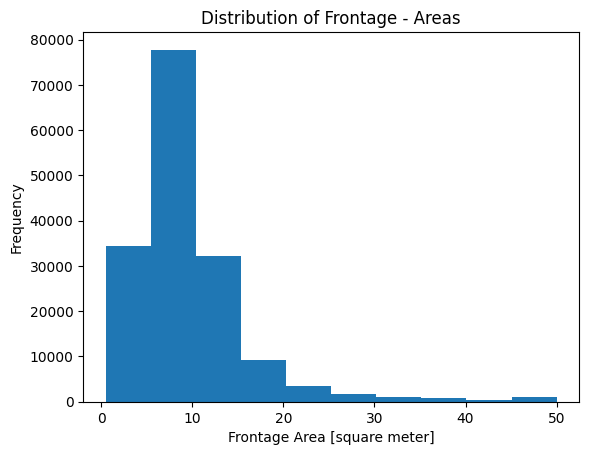

In [43]:
# nota-se que o tamanho da fachada mais comum é entre 5m2 - 9m2.
# contudo, por existir valores faltando, vou substituir pela mediana, que são 8m2
plt.hist(df_treino['Frontage'])
plt.xlabel('Frontage Area [square meter]')
plt.ylabel('Frequency')
plt.title('Distribution of Frontage - Areas');

In [44]:
print(f"A média do Frontage é {df_treino['Frontage'].mean()}")
print(f"A mediana do Frontage é {df_treino['Frontage'].median()}")
print(f"O tamanho mínimo do Frontage é {df_treino['Frontage'].min()}")
print(f"O tamanho máximo do Frontage é {df_treino['Frontage'].max()}")

A média do Frontage é 9.630813433158247
A mediana do Frontage é 8.0
O tamanho mínimo do Frontage é 0.5
O tamanho máximo do Frontage é 50.0


In [45]:
# Preenchendo valores nulos com a mediana geral
df_treino['Frontage'].fillna(df_treino['Frontage'].median(), inplace=True)


### FrontageIsGreaterFlag - Indica 1, se a fachada for > 50m2

In [46]:
# a coluna está vazia. Porém, isto não é um problema. 
# Podemos atribuir valores usando função lambda
df_treino['FrontageIsGreaterFlag'].describe()

count       0
unique      0
top       NaN
freq      NaN
Name: FrontageIsGreaterFlag, dtype: object

In [47]:
df_treino['FrontageIsGreaterFlag'] = df_treino['Frontage'].apply(lambda x: 1 if x >= 50 else 0)

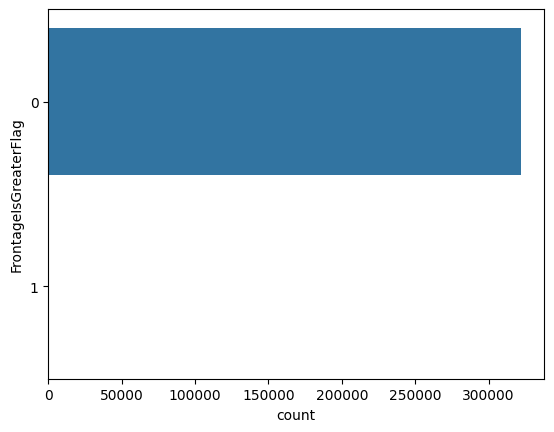

In [48]:
# como vimos anteriormente, a grande maioria das fachadas das casas tem de 5m2 - 9m2
# talvez devemos fazer uma analise para ver se casas que tem acima de 50m2
# deveriam ser retirados do data set e essa várial ser excluída.
sns.countplot(y='FrontageIsGreaterFlag', data = df_treino);

In [49]:
# não há fachadas que tenha mais de 50m2, portanto, vou excluir essa coluna.
df_treino.drop(columns=['FrontageIsGreaterFlag'], inplace=True)

### TotalFloorArea - Area total do piso em m2

In [50]:
# aqui também temos parte da amostra com valores faltando.
# Como a média e mediana são bem discrepantes, eu vou agrupar por municípios 
# e atribuir os NA pela mediana de cada município correspondente

print(f"A média do TotalFloorArea é {df_treino['TotalFloorArea'].mean()}")
print(f"A mediana do TotalFloorArea é {df_treino['TotalFloorArea'].median()}")
print(f"O tamanho mínimo do TotalFloorArea é {df_treino['TotalFloorArea'].min()}")
print(f"O tamanho máximo do TotalFloorArea é {df_treino['TotalFloorArea'].max()}")


A média do TotalFloorArea é 172.84728023869636
A mediana do TotalFloorArea é 95.0
O tamanho mínimo do TotalFloorArea é 10.0
O tamanho máximo do TotalFloorArea é 2000.0


In [51]:
df_treino['TotalFloorArea'] = df_treino['TotalFloorArea'].astype(float)
df_treino['TotalFloorArea'] = df_treino.groupby('Municipality')['TotalFloorArea'].transform(lambda x: x.fillna(x.median()))


### TotalFloorAreaIsGreaterFlag - Area do piso é >= a 2000m2


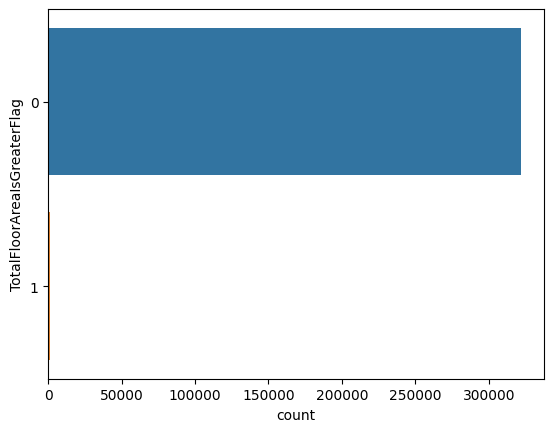

In [52]:
sns.countplot(y='TotalFloorAreaIsGreaterFlag', data = df_treino);

In [53]:
percent_ones = (df_treino['TotalFloorAreaIsGreaterFlag'].sum() / len(df_treino)).round(4)
print(f"A porcentagem do número de imóveis com tamanho > 2000m² é: {percent_ones * 100}%")

A porcentagem do número de imóveis com tamanho > 2000m² é: 0.3%


In [54]:
# Somente 0.3% tem casa com tamanho de pisos superior a 2000m2
# Acho que podemos excluir essa variável.
df_treino.drop(columns=['TotalFloorAreaIsGreaterFlag'], inplace=True)

### Building Year - Ano de construção do edifício

In [55]:
# Temos outro problema. Aqui também temos valores faltando e o substituição desses
# valores pode não parecer tão trivial. Portanto,vamos analisar com calma
# utilizando algumas estatísticas básicas.

print(f"A mediana do BuildingYear é {df_treino['BuildingYear'].median()}")
print(f"O tamanho mínimo do BuildingYear é {df_treino['BuildingYear'].min()}")
print(f"O tamanho máximo do BuildingYear é {df_treino['BuildingYear'].max()}")

A mediana do BuildingYear é 2001.0
O tamanho mínimo do BuildingYear é 1945
O tamanho máximo do BuildingYear é 2020


In [56]:
correlation_matrix = df_treino[['BuildingYear', 'TradePrice']].corr()

# Exibindo a matriz de correlação
print(correlation_matrix)

              BuildingYear  TradePrice
BuildingYear      1.000000   -0.020633
TradePrice       -0.020633    1.000000


Observando essa matriz de correlação, podemos interpretar da seguinte forma: a medida que a casa/apartamento é mais novo, menor será o preço, **que é totalmente contraintuitivo**. Contudo, a relação aqui não mostra muita força, uma vez que está muito próximo a zero. Além disso, outros fatores devem ser levados em consideração. Ainda assim, existem valores a serem preenchidos.

A estratégia que utilizei, semelhante ao que foi apresentado anteriormente, consiste em atribuir a **moda** para os anos que estão faltando. A ideia é que, à medida que novos locais são habitados, novas casas ou apartamentos são construídos em resposta à demanda. Portanto, é provável que as construções nas proximidades tenham idades semelhantes.

In [57]:
# substituir os valores nulos em anos em que houveram mais construções em cada município 
df_treino['BuildingYear'] = df_treino.groupby('Municipality')['BuildingYear'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else None))

### PrewarBuilding


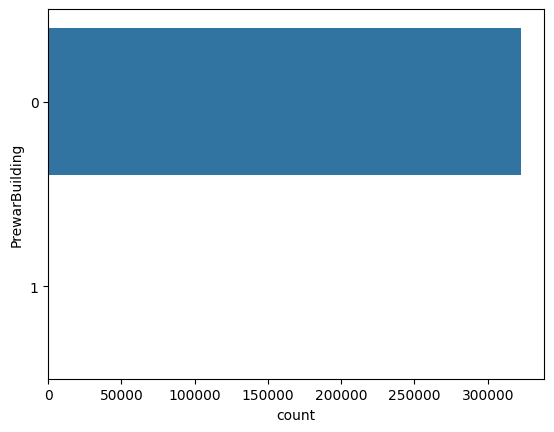

In [58]:
sns.countplot(y='PrewarBuilding', data = df_treino);

In [59]:
percent_ones = (df_treino['PrewarBuilding'].sum() / len(df_treino)).round(4)
print(f"A porcentagem do número de imóveis construídos antes de 1945 é: {percent_ones * 100}%")

A porcentagem do número de imóveis construídos antes de 1945 é: 0.08%


In [60]:
# Somente 0.08% são locais construídos antes de 1945
# Acho que podemos excluir essa variável.
df_treino.drop(columns=['PrewarBuilding'], inplace=True)

### Structure - Tipo de estrutura do edifício


In [61]:
# temos uma quantia consideravel de variáveis sem classificação e outra
# com poucas observações.  
df_treino["Structure"].value_counts()

Structure
RC             105726
W               85902
                70294
SRC             46887
S               10090
LS               2627
RC, W             585
S, W              148
SRC, RC           119
RC, S             100
B                  95
W, LS              15
W, B               13
SRC, S             11
RC, LS              7
S, LS               6
S, B                5
RC, S, W            4
RC, B               4
RC, W, B            3
SRC, W              3
RC, S, B            1
RC, S, W, B         1
RC, S, LS           1
S, W, LS            1
Name: count, dtype: Int64

In [62]:
# vamos nomear os missing para "Other Structure"
df_treino['Structure'] = df_treino['Structure'].replace("", "Other Structure")

In [63]:
# quero manter algumas categorias e somar as demais em "Other Structure"
categorias_manter = ["RC", "W", "Other Structure", "SRC", "S", "LS", "RC, W"]
df_treino['Structure'] = df_treino['Structure'].apply(lambda x: x if x in categorias_manter else "Other Structure")

print(df_treino['Structure'].value_counts())


Structure
RC                 105726
W                   85902
Other Structure     70831
SRC                 46887
S                   10090
LS                   2627
RC, W                 585
Name: count, dtype: int64


### Use - Uso atual do imóvel 

In [64]:
df_treino["Use"].value_counts()

Use
House                                             217751
                                                   77998
Housing Complex                                     9489
House, Shop                                         2206
Office                                              2158
                                                   ...  
Factory, Office, Warehouse, Parking Lot, Shop          1
House, Parking Lot, Shop, Other                        1
Housing Complex, Office, Workshop, Parking Lot         1
Office, Warehouse, Shop, Other                         1
Housing Complex, Workshop, Parking Lot                 1
Name: count, Length: 201, dtype: Int64

In [65]:
df_treino["Use"].nunique()

201

In [66]:
# quantidade de strings vazias
num_vazios = (df_treino['Use'] == "").sum()
print(f"Existem {num_vazios} valores vazios na coluna 'Use'.")


Existem 77998 valores vazios na coluna 'Use'.


In [67]:
# renomear as colunas vazias para "Other Use""
df_treino['Use'] = df_treino['Use'].replace("", "Other Use")

### Purpose - Propósito de uso futuro

In [68]:
df_treino["Purpose"].value_counts()

Purpose
             196922
House        109758
Other         11169
Office         2565
Shop           1561
Warehouse       445
Factory         228
Name: count, dtype: Int64

In [69]:
# Vamos criar 4 classificações: Residential, Commercial, Industrial e Others
def classificar_purpose(valor):
    if valor == "House":
        return "Residential"
    elif valor in ["Shop", "Office"]:
        return "Commercial"
    elif valor in ["Warehouse", "Factory"]:
        return "Industrial"
    else:
        return "Others"

# Aplicando a função para classificar os valores
df_treino['Purpose_Category'] = df_treino['Purpose'].apply(classificar_purpose)
print(df_treino['Purpose_Category'].value_counts())


Purpose_Category
Others         208091
Residential    109758
Commercial       4126
Industrial        673
Name: count, dtype: int64


### Direction - Direção da fachada


In [70]:
df_treino["Direction"].value_counts()

Direction
                  145911
South              27942
North              26550
East               25791
West               25466
Southeast          17907
Southwest          17453
Northwest          17362
Northeast          16303
No facing road      1963
Name: count, dtype: Int64

In [71]:
# muito valores faltando, sem direção clara da fachada.
# vou nomear Other direction
df_treino['Direction'] = df_treino['Direction'].replace("", "Other Direction")

### Classification - Classificação da via em frente

In [72]:
df_treino["Classification"].value_counts()

Classification
                                 147874
Ward Road                         74070
Private Road                      43294
City Road                         41176
Tokyo Metropolitan Road            7771
Road                               4615
National Highway                   1439
Town Road                          1186
Access Road                         656
Village Road                        249
Agricultural Road                    98
Prefectural Road                     76
Hokkaido Prefectural Road            70
Forest Road                          63
Kyoto/ Osaka Prefectural Road        11
Name: count, dtype: Int64

In [73]:
df_treino['Classification'] = df_treino['Classification'].replace("", "No Classification")

### Breadth - Largura da via em frente (m)

In [74]:
# Calcula a média e a mediana de 'breadth' por 'Municipality'
print(f"A média do Breadth é {df_treino['Breadth'].mean()}")
print(f"A mediana do Breadth é {df_treino['Breadth'].median()}")

media_mediana_por_municipio = df_treino.groupby('Municipality')['Breadth'].agg(['mean', 'median'])

print(media_mediana_por_municipio)

A média do Breadth é 6.248128056146809
A mediana do Breadth é 5.0
                                        mean  median
Municipality                                        
Adachi Ward                         6.650403    5.50
Akiruno City                        5.902284    5.00
Akishima City                       6.136192    5.00
Arakawa Ward                        6.008068    4.00
Bunkyo Ward                         6.687080    4.00
Chiyoda Ward                       12.635233    8.00
Chofu City                          5.459796    4.50
Chuo Ward                          12.218202   10.00
Edogawa Ward                        6.767071    5.40
Fuchu City                          6.003664    5.00
Fussa City                          6.996883    6.00
Hachijo Town                        5.671282    5.00
Hachioji City                       6.470117    6.00
Hamura City                         6.928620    6.00
Higashikurume City                  5.679418    5.00
Higashimurayama City             

In [75]:
# Substitui os valores nulos na coluna 'breadth' pela média do município correspondente
df_treino['Breadth'] = df_treino.groupby('Municipality')['Breadth'].transform(lambda x: x.fillna(x.mean()))


### CityPlanning - Uso dos distritos designados pela Lei de Planejamento Urbano


In [76]:
df_treino["CityPlanning"].value_counts()

CityPlanning
Category I Exclusively Low-story Residential Zone       80691
Commercial Zone                                         56369
Category I Exclusively Medium-high Residential Zone     45805
Quasi-industrial Zone                                   44467
Category I Residential Zone                             35050
Neighborhood Commercial Zone                            30527
Category II Exclusively Medium-high Residential Zone     7950
Category II Residential Zone                             6493
Industrial Zone                                          4405
Quasi-residential Zone                                   4272
                                                         2859
Category II Exclusively Low-story Residential Zone       2337
Urbanization Control Area                                 531
Non-divided City Planning Area                            519
Exclusively Industrial Zone                               243
Outside City Planning Area                               

In [77]:
# Contar a quantidade de valores que são strings vazias
city_vazios = (df_treino['CityPlanning'] == "").sum()
print(f"Existem {city_vazios} valores vazios na coluna 'CityPlanning'.")


Existem 2859 valores vazios na coluna 'CityPlanning'.


In [78]:
df_treino['CityPlanning'] = df_treino['CityPlanning'].replace("", "Other Urban Use")

### CoverageRatio - Percentual máximo de cobertura do edifício (%)


In [79]:
# Calcula a média e a mediana de 'CoverageRatio' por 'Municipality'
media_mediana_coverageratio = df_treino.groupby('Municipality')['CoverageRatio'].agg(['mean', 'median'])

print(f"A média do CoverageRatio é {df_treino['CoverageRatio'].mean()}")
print(f"A mediana do CoverageRatio é {df_treino['CoverageRatio'].median()}")

print(media_mediana_coverageratio)

A média do CoverageRatio é 62.08568016092532
A mediana do CoverageRatio é 60.0
                                        mean  median
Municipality                                        
Adachi Ward                        62.807703    60.0
Akiruno City                       46.088398    40.0
Akishima City                      53.682540    60.0
Arakawa Ward                       74.541042    80.0
Bunkyo Ward                        71.269354    80.0
Chiyoda Ward                       77.963462    80.0
Chofu City                         52.747551    50.0
Chuo Ward                          77.357143    80.0
Edogawa Ward                       62.256559    60.0
Fuchu City                         55.684231    60.0
Fussa City                         57.417085    60.0
Hachijo Town                       69.347826    70.0
Hachioji City                      52.547259    50.0
Hamura City                        55.110497    60.0
Higashikurume City                 48.831993    40.0
Higashimurayama City

In [80]:
df_treino['CoverageRatio'] = df_treino.groupby('Municipality')['CoverageRatio'].transform(lambda x: x.fillna(x.mean()))

### FloorAreaRatio - Percentual máximo da área do piso (%)


In [81]:
# Calcula a média e a mediana de 'FloorAreaRatio' por 'Municipality'
media_mediana_FloorAreaRatio = df_treino.groupby('Municipality')['FloorAreaRatio'].agg(['mean', 'median'])

print(f"A média do FloorAreaRatio é {df_treino['FloorAreaRatio'].mean()}")
print(f"A mediana do FloorAreaRatio é {df_treino['FloorAreaRatio'].median()}")

# Exibe o resultado
print(media_mediana_FloorAreaRatio)

A média do FloorAreaRatio é 264.73563615790795
A mediana do FloorAreaRatio é 200.0
                                         mean  median
Municipality                                         
Adachi Ward                        256.147889   200.0
Akiruno City                       102.889503    80.0
Akishima City                      160.181406   200.0
Arakawa Ward                       371.755645   300.0
Bunkyo Ward                        415.416444   400.0
Chiyoda Ward                       576.609763   600.0
Chofu City                         157.435897   100.0
Chuo Ward                          551.481481   500.0
Edogawa Ward                       249.044726   200.0
Fuchu City                         185.107122   200.0
Fussa City                         186.964824   200.0
Hachijo Town                       200.543478   200.0
Hachioji City                      167.610703   150.0
Hamura City                        168.462247   200.0
Higashikurume City                 129.885738    80.0

In [82]:
df_treino['FloorAreaRatio'] = df_treino.groupby('Municipality')['FloorAreaRatio'].transform(lambda x: x.fillna(x.mean()))

### Period - Tempo da transação


In [83]:
df_treino['Period'].value_counts()

Period
1st quarter 2013    6799
2nd quarter 2013    6773
3rd quarter 2013    6717
1st quarter 2015    6715
1st quarter 2016    6667
3rd quarter 2016    6574
1st quarter 2017    6556
3rd quarter 2015    6533
3rd quarter 2017    6495
4th quarter 2013    6482
1st quarter 2018    6481
1st quarter 2014    6454
2nd quarter 2016    6441
4th quarter 2014    6436
4th quarter 2012    6430
4th quarter 2015    6419
4th quarter 2016    6418
2nd quarter 2015    6381
4th quarter 2018    6353
4th quarter 2017    6334
3rd quarter 2014    6293
3rd quarter 2018    6287
1st quarter 2019    6256
1st quarter 2010    6225
2nd quarter 2018    6215
4th quarter 2010    6209
3rd quarter 2010    6090
1st quarter 2011    6057
3rd quarter 2012    6022
4th quarter 2011    5911
1st quarter 2012    5885
2nd quarter 2017    5834
2nd quarter 2010    5818
4th quarter 2009    5807
2nd quarter 2012    5783
2nd quarter 2014    5732
3rd quarter 2011    5703
3rd quarter 2009    5696
2nd quarter 2019    5581
2nd quarter 2009  

### Year - Ano da transação

In [84]:
# Converte a coluna 'Year' para datetime
#df_treino['Year'] = pd.to_datetime(df_treino['Year'], format='%Y')


In [85]:
df_treino['Year'].describe()

count       322648.0
mean     2012.600214
std         3.900629
min           2005.0
25%           2009.0
50%           2013.0
75%           2016.0
max           2019.0
Name: Year, dtype: Float64

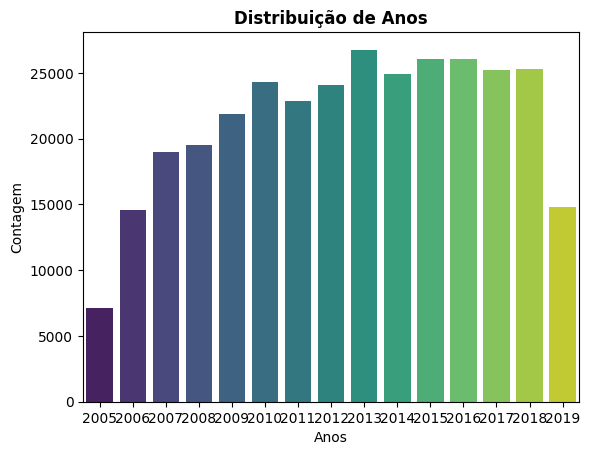

In [86]:
sns.countplot(data=df_treino, x='Year', palette='viridis')

# Títulos e rótulos
plt.title('Distribuição de Anos', fontweight='bold')
plt.xlabel('Anos')
plt.ylabel('Contagem')

# Exibir o gráfico
plt.show()

### Quarter

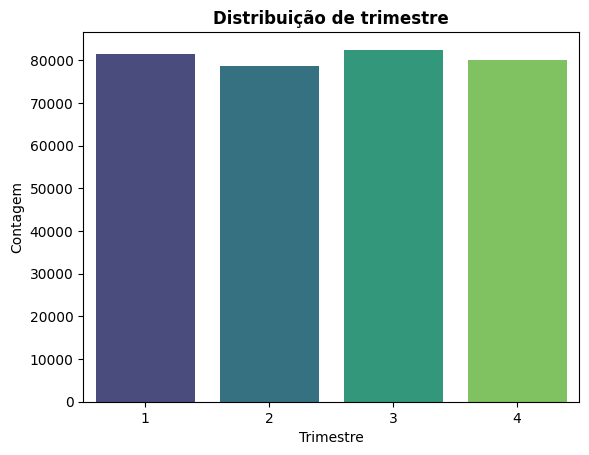

In [87]:
# distribuiçao bem semelhantes
sns.countplot(data=df_treino, x='Quarter', palette='viridis')
plt.title('Distribuição de trimestre', fontweight='bold')
plt.xlabel('Trimestre')
plt.ylabel('Contagem')
plt.show()

### Renovation

In [88]:
#muito missings aqui também
df_treino['Renovation'].value_counts()

Renovation
           191284
Not yet     96649
Done        34715
Name: count, dtype: Int64

In [89]:
df_treino['Renovation'] = df_treino['Renovation'].replace("", "Unknown Renovation")

### Remarks

In [90]:
#muito missings aqui também
df_treino['Remarks'].value_counts()

Remarks
                                                                                                                      300348
Dealings including private road                                                                                        17213
Dealings in which auction or arbiter participates                                                                       1854
Dealings of adjacent land                                                                                               1623
Dealings between related objects                                                                                         843
Dealings in which auction or arbiter participates,Dealings including private road                                        351
Dealings of adjacent land,Dealings including private road                                                                166
Dealings between related objects,Dealings including private road                                                     

### TradePrice

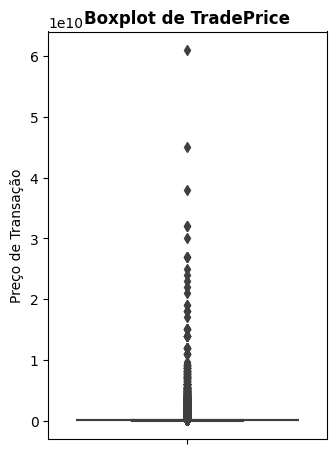

In [91]:
# Verificando outliers de 'TradePrice'
plt.subplot(1, 2, 2)
sns.boxplot(data=df_treino, y='TradePrice')
plt.title('Boxplot de TradePrice', fontweight='bold')
plt.ylabel('Preço de Transação')

plt.tight_layout()
plt.show()

In [92]:
# estatística básicas para preço dos imóveis
df_treino['TradePrice'].describe()

count            322648.0
mean      66466372.912896
std      325817335.222341
min                1000.0
25%            22000000.0
50%            35000000.0
75%            54000000.0
max         61000000000.0
Name: TradePrice, dtype: Float64

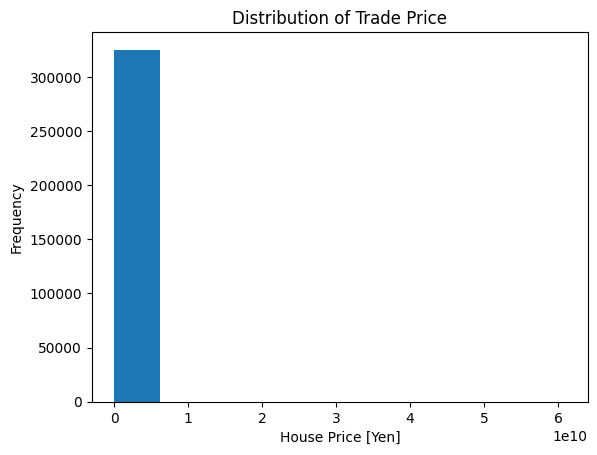

In [93]:
# Distribuição dos valores
plt.hist(df['TradePrice'])
plt.xlabel('House Price [Yen]')
plt.ylabel('Frequency')
plt.title('Distribution of Trade Price');

In [94]:
# mesmo após substituir algiuns NaN's, sobrou alguns valores faltantes, uma vez que necessitavam
# de outros valores que também estavam ausentes. E como a quantidade de pouca em função do volume 
# de dados vou dropar estes também

df_treino.dropna(subset=['MinTimeToNearestStation', 'MaxTimeToNearestStation', 'CoverageRatio', 'FloorAreaRatio'], inplace=True)


### Verificando se há missings values pós tratamento

In [95]:
df_treino.isna().sum()

Type                       0
Region                     0
MunicipalityCode           0
Municipality               0
DistrictName               0
NearestStation             0
TimeToNearestStation       0
MinTimeToNearestStation    0
MaxTimeToNearestStation    0
FloorPlan                  0
Area                       0
UnitPrice                  0
LandShape                  0
Frontage                   0
TotalFloorArea             0
BuildingYear               0
Structure                  0
Use                        0
Purpose                    0
Direction                  0
Classification             0
Breadth                    0
CityPlanning               0
CoverageRatio              0
FloorAreaRatio             0
Period                     0
Year                       0
Quarter                    0
Renovation                 0
Remarks                    0
TradePrice                 0
Purpose_Category           0
dtype: int64

## Análise Exploratória de Dados

In [96]:
df2 = df_treino.copy() 

### Distribuição de variáveis numéricas

In [97]:
num_attributes = df2.select_dtypes(include=['int64', 'float64'])

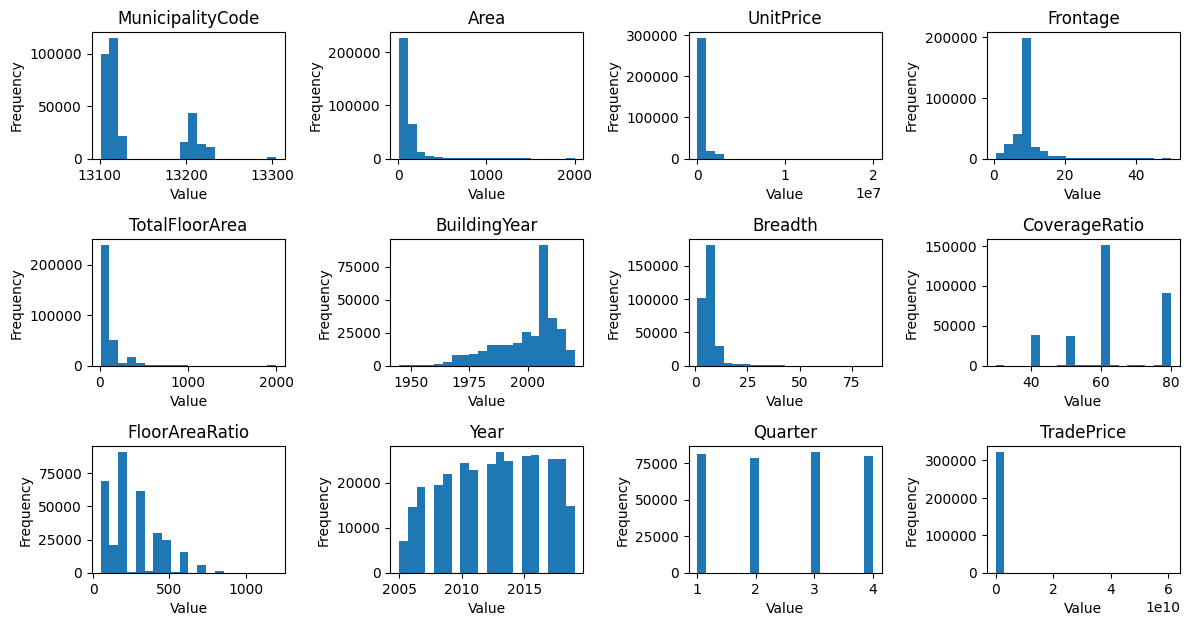

In [98]:
plt.figure(figsize=(12,8))

for i, column in enumerate(num_attributes, 1):
    plt.subplot(4,4,i)
    plt.hist(df2[column], bins=20)
    plt.title(column)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Distribuição de variáveis categóricas

In [99]:
cat_attributes = df2.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

/var/folders/8w/w_32s28d2jx8vh00xqr09glc0000gn/T/ipykernel_10640/3232005195.py:12: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


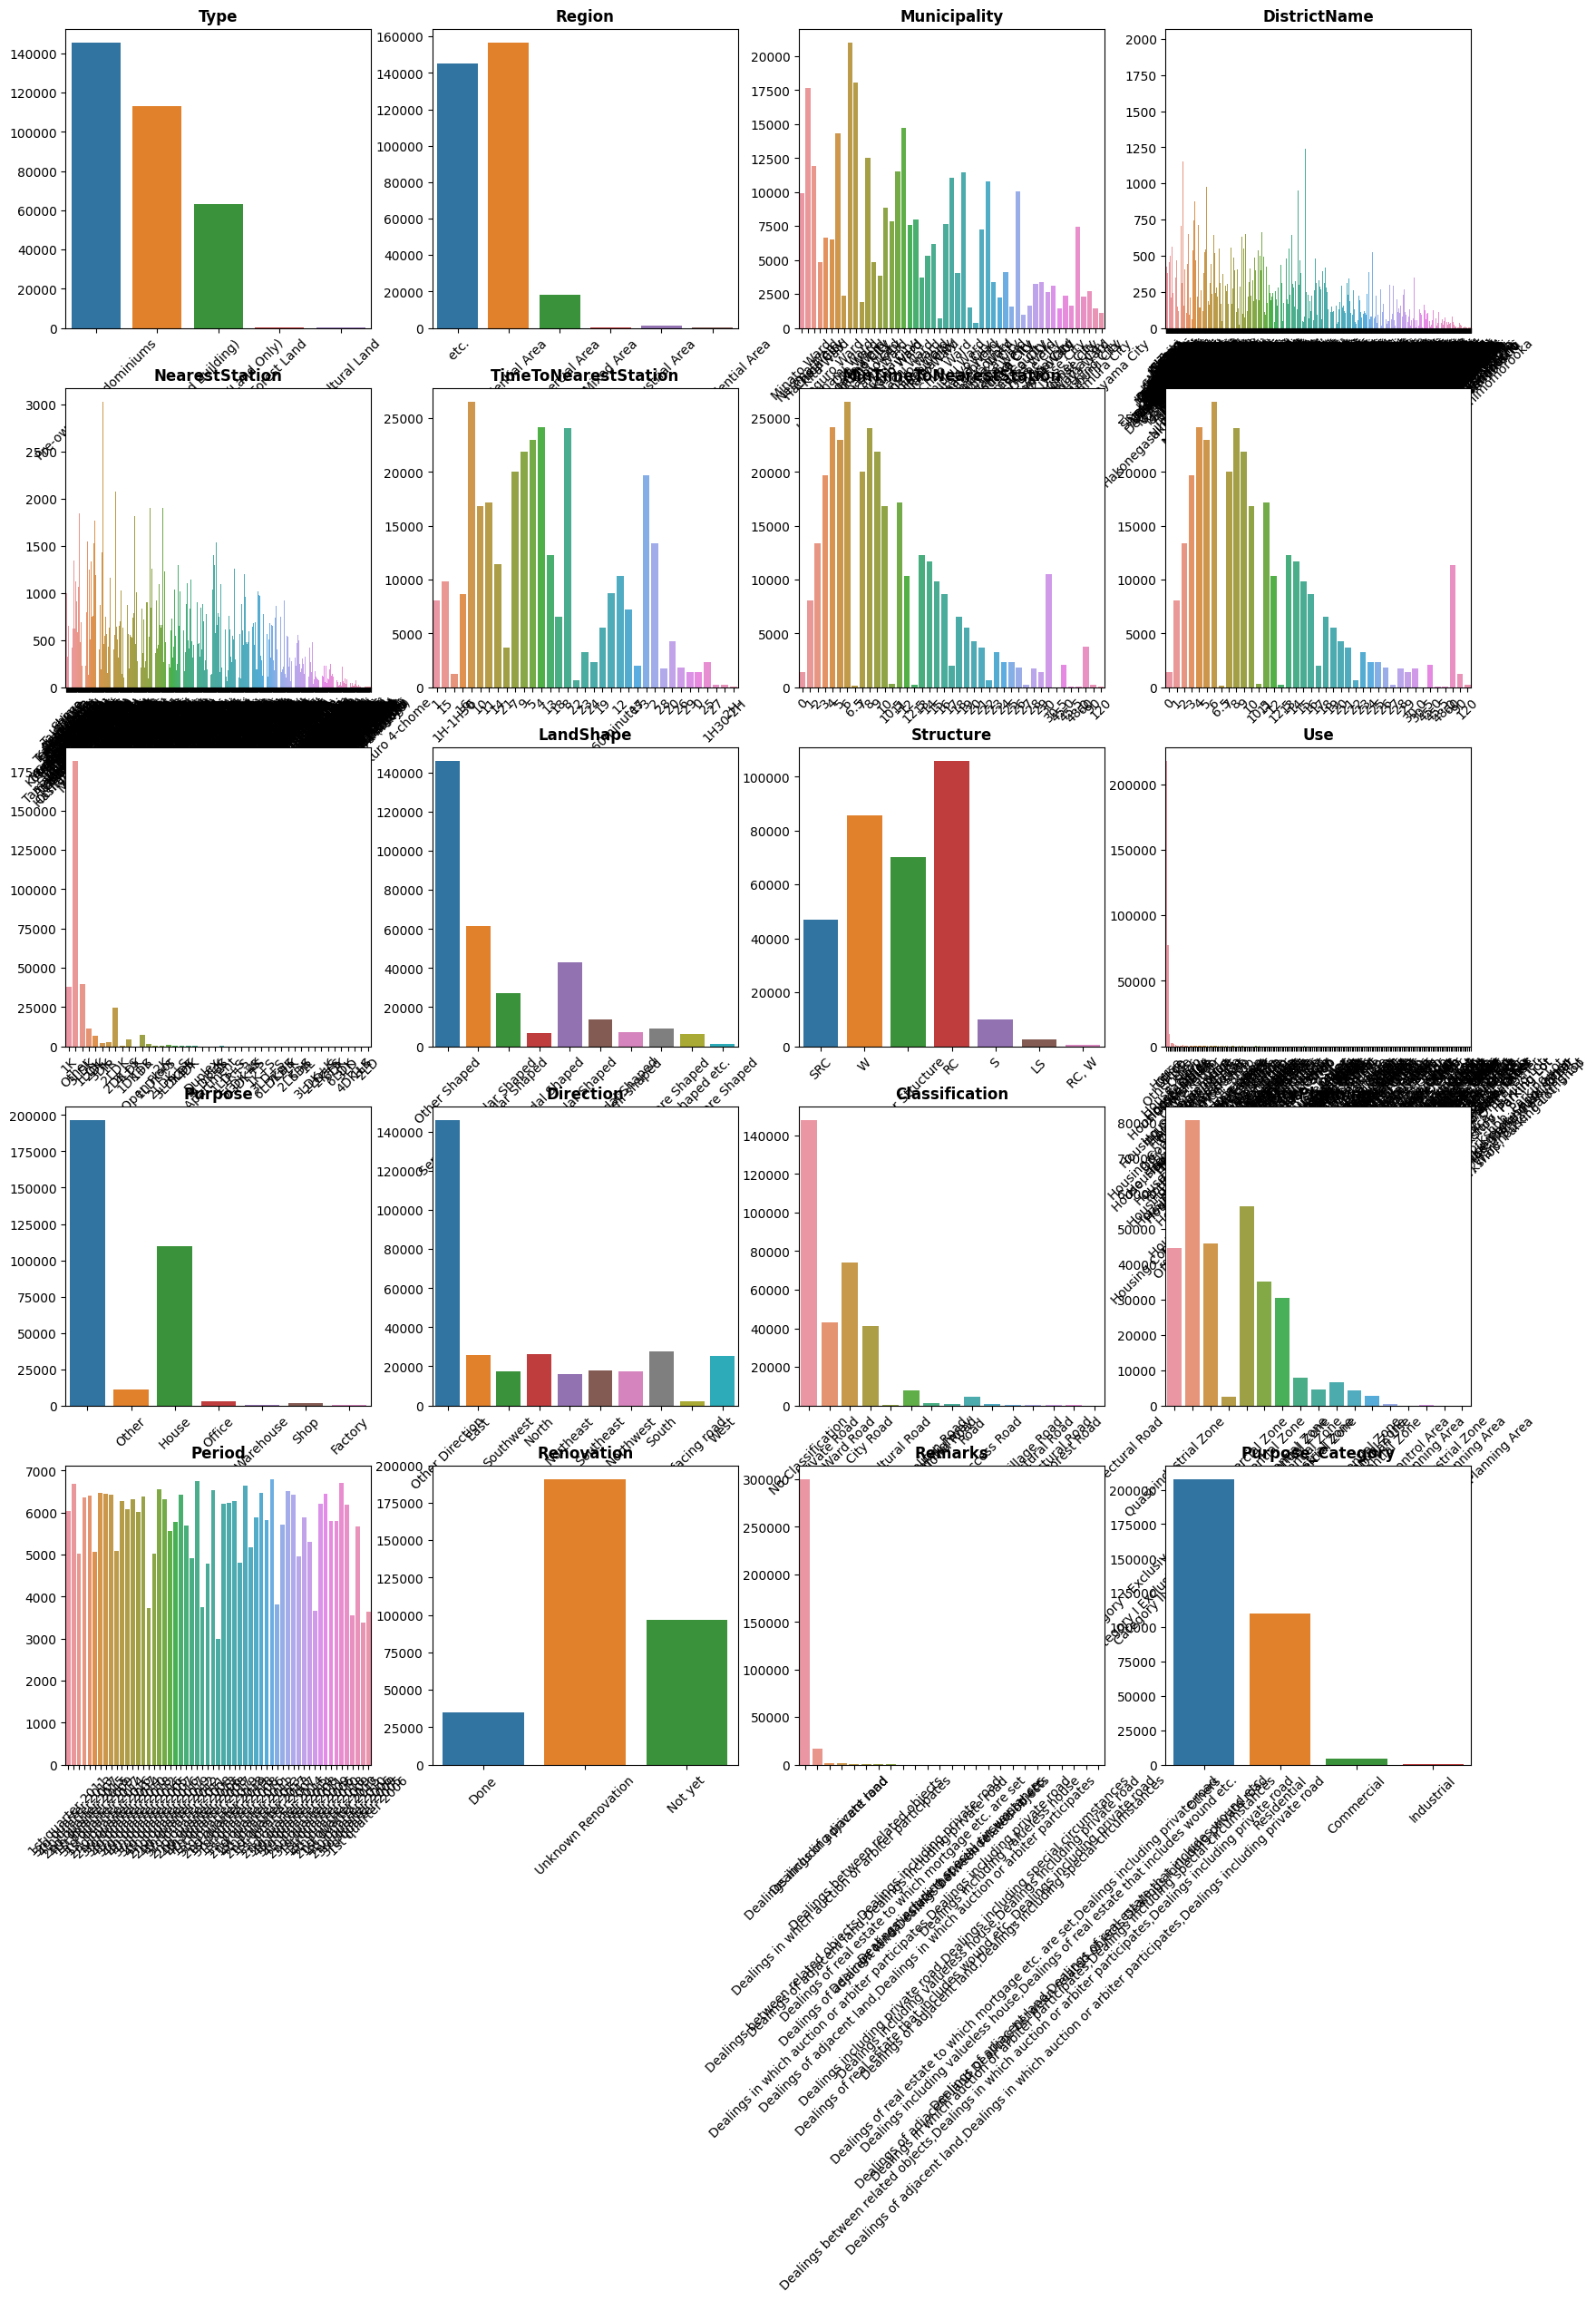

In [100]:
plt.figure(figsize=(20, 30))

for i, column in enumerate(cat_attributes, 1):
    if df2[column].notna().sum() > 0:  # Verifica se a coluna não está vazia
        plt.subplot(6, 4, i)
        sns.countplot(data=df2, x=column)
        plt.title(column, fontweight='bold')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Construção de Hipóteses - em busca de insights

RESPONDENDO A ALGUMAS PERGUNTAS
1. Qual município que tem maior e menor valores?
2. Qual município que tem maior propriedades ?
3. Qual é a distribuição das propriedades por categoria de uso (residencial, comercial, etc.) em cada município?
4. Qual a relação entre os tempos (min e max) até a estação e os preços dos imóveis.
5. Qual a média e mediana do preço de venda para cada Trimestre ao longo dos anos?
6. Qual a média de preços para os tipos de formato do imóvel?

### 1. Qual município que tem maior e menor valores?

In [101]:
# Agrupa o município pelo preço médio
mean_by_municipality = (df2.groupby('Municipality')['TradePrice'].mean()
    .sort_values(ascending=False).round(2))

mean_by_municipality

Municipality
Chiyoda Ward                    227960548.03
Minato Ward                     172019409.87
Shibuya Ward                    144400069.96
Chuo Ward                       134777407.79
Meguro Ward                      94099428.97
Musashino City                   89288612.92
Shinjuku Ward                    80709386.45
Setagaya Ward                    77589127.97
Taito Ward                       77248848.27
Shinagawa Ward                   75560192.56
Bunkyo Ward                      71574062.01
Mitaka City                       70876222.3
Nakano Ward                      67301072.66
Toshima Ward                     67048220.97
Koto Ward                        66884116.78
Suginami Ward                    66072940.64
Ota Ward                         62129045.01
Kunitachi City                   59264838.07
Sumida Ward                      58045071.78
Nerima Ward                      54325632.09
Chofu City                       53012770.71
Komae City                       52840730.

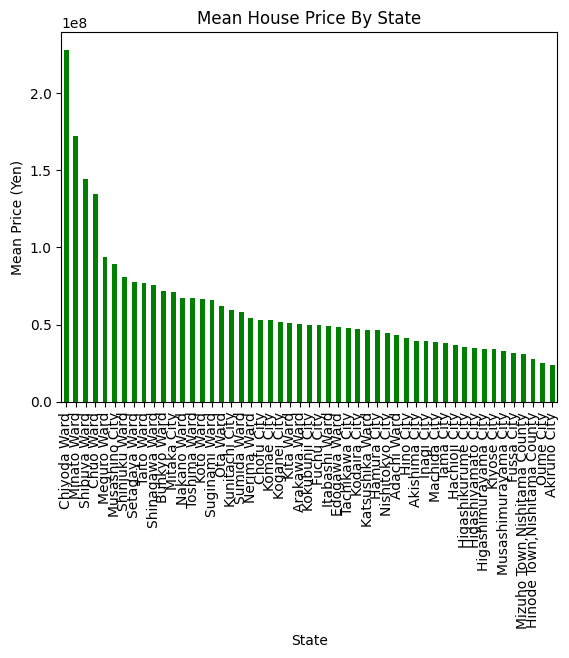

In [102]:
# visualizing mean price by state
mean_by_municipality.plot(
    kind='bar',
    xlabel='State',
    ylabel='Mean Price (Yen)',
    title='Mean House Price By State',
    color='green');

De acordo com este site (https://housingjapan.com/blog/your-guide-to-the-top-3-wealthiest-wards-in-tokyo/), atualizado em 17 de Junho de 2024, os três primeiros munícipios são os mais ricos, o que naturalmente, podem ter o preço dos imóveis mais caros. A única diferença que a ordem do 1o e 2o lugar estão invertidos, o Chiyoda Ward esta em 2o, enquanto que o Minato Ward está em primeiro município mais rico.

Os municípios com a menor média do valor do imóvel são Oume City e Akiruno City.

Vamos averiguar acerca do preço médio do metro quadrado por município.
De qualquer forma, vamos continuar explorando. 

In [103]:
mean_unitprice = (df_treino.groupby('Municipality')['UnitPrice'].mean().round(2).sort_values(ascending=False))
mean_unitprice


Municipality
Chuo Ward                       2034216.87
Chiyoda Ward                    2019203.70
Minato Ward                     1930089.06
Shibuya Ward                    1185301.95
Shinjuku Ward                    805205.68
Bunkyo Ward                      792428.79
Taito Ward                       778248.35
Meguro Ward                      759826.67
Shinagawa Ward                   660081.83
Toshima Ward                     611805.64
Setagaya Ward                    585937.61
Koto Ward                        520222.08
Nakano Ward                      514180.91
Ota Ward                         513737.37
Musashino City                   508604.00
Suginami Ward                    502487.68
Sumida Ward                      501912.62
Kita Ward                        439370.99
Arakawa Ward                     403305.59
Itabashi Ward                    384093.21
Nerima Ward                      368854.24
Mitaka City                      347861.32
Chofu City                       337079.0

Note que Chiyoda Ward é sem dúvidas o metro quadrado mais caro de Tokyo. Em uma breve observação, o município figura entre os top 3, bem como o Minato Ward.

Os locais com areas mais baratas também são Oume City e Akiruno City

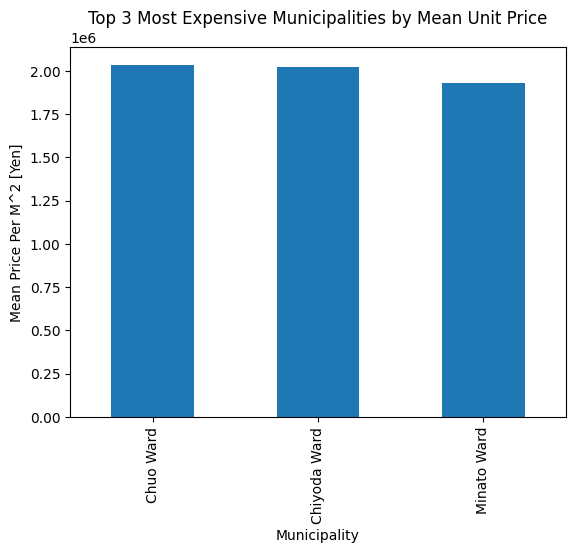

In [104]:
top_3 = df_treino.groupby('Municipality')['UnitPrice'].mean().nlargest(3)

# Plota o gráfico de barras
top_3.plot(
    kind='bar',
    xlabel='Municipality',
    ylabel='Mean Price Per M^2 [Yen]',
    title='Top 3 Most Expensive Municipalities by Mean Unit Price');


### 2. Qual município que tem maior propriedades ?

In [105]:
municip_count = df['Municipality'].value_counts()
municip_count

Municipality
Setagaya Ward                        21062
Ota Ward                             18267
Nerima Ward                          17788
Adachi Ward                          14763
Suginami Ward                        14385
Itabashi Ward                        12590
Hachioji City                        12008
Koto Ward                            11679
Edogawa Ward                         11472
Shinjuku Ward                        11219
Shinagawa Ward                       10914
Katsushika Ward                      10088
Minato Ward                          10010
Machida City                          8875
Toshima Ward                          8120
Nakano Ward                           7865
Chuo Ward                             7769
Bunkyo Ward                           7709
Shibuya Ward                          7462
Sumida Ward                           7410
Kita Ward                             6801
Meguro Ward                           6552
Taito Ward                            631

Os municípios que mais tem imóveis são Setagaya, Ota Ward e Nerima Ward. De acordo com dados encontrados no wikipedia, essas três regiões são as regiões que tem maior população. Faz sentido ter disponibilidade para um maior numero de moradores. Um fato curiosos sobre o Japão é que sua popualção esta envelhecendo e a idade média é de 49 anos.

In [106]:
df2.columns

Index(['Type', 'Region', 'MunicipalityCode', 'Municipality', 'DistrictName',
       'NearestStation', 'TimeToNearestStation', 'MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'FloorPlan', 'Area', 'UnitPrice',
       'LandShape', 'Frontage', 'TotalFloorArea', 'BuildingYear', 'Structure',
       'Use', 'Purpose', 'Direction', 'Classification', 'Breadth',
       'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year',
       'Quarter', 'Renovation', 'Remarks', 'TradePrice', 'Purpose_Category'],
      dtype='object')

### 3. Qual é o tipo de estrutura mais cara, em média?

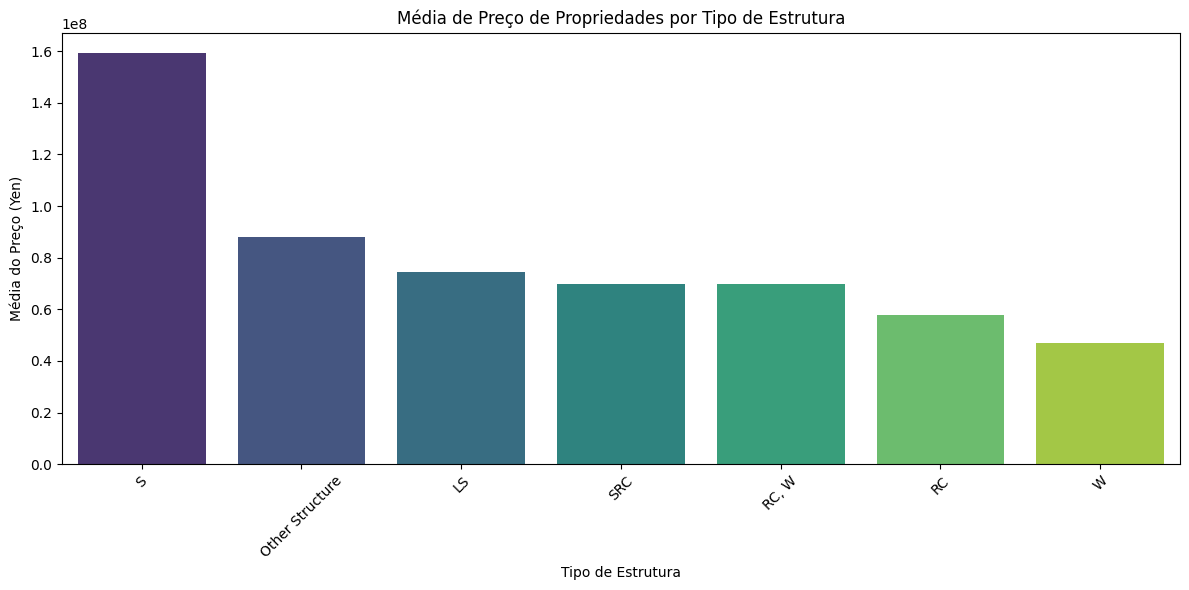

In [107]:
avg_price_by_structure = df_treino.groupby('Structure')['TradePrice'].mean().sort_values(ascending=False)

# Plotando o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price_by_structure.index, y=avg_price_by_structure.values, palette='viridis')
plt.title("Média de Preço de Propriedades por Tipo de Estrutura")
plt.xlabel("Tipo de Estrutura")
plt.ylabel("Média do Preço (Yen)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Estruturas que tem média de preço mais alta podem ser consideradas mais valorizadas no mercado, por exemplo o estruturas de aço (steel) são bem mais valorizadas do que concreto armado (RC). 

Um possível insight aqui é que o Japão por conter muitos terremotos, o aço tem maior durabilidade e flexibilidade para sustentar o prédio durante essas atividades sísmicas

### 4. Qual a relação entre os tempos (min e max) até a estação e os preços dos imóveis

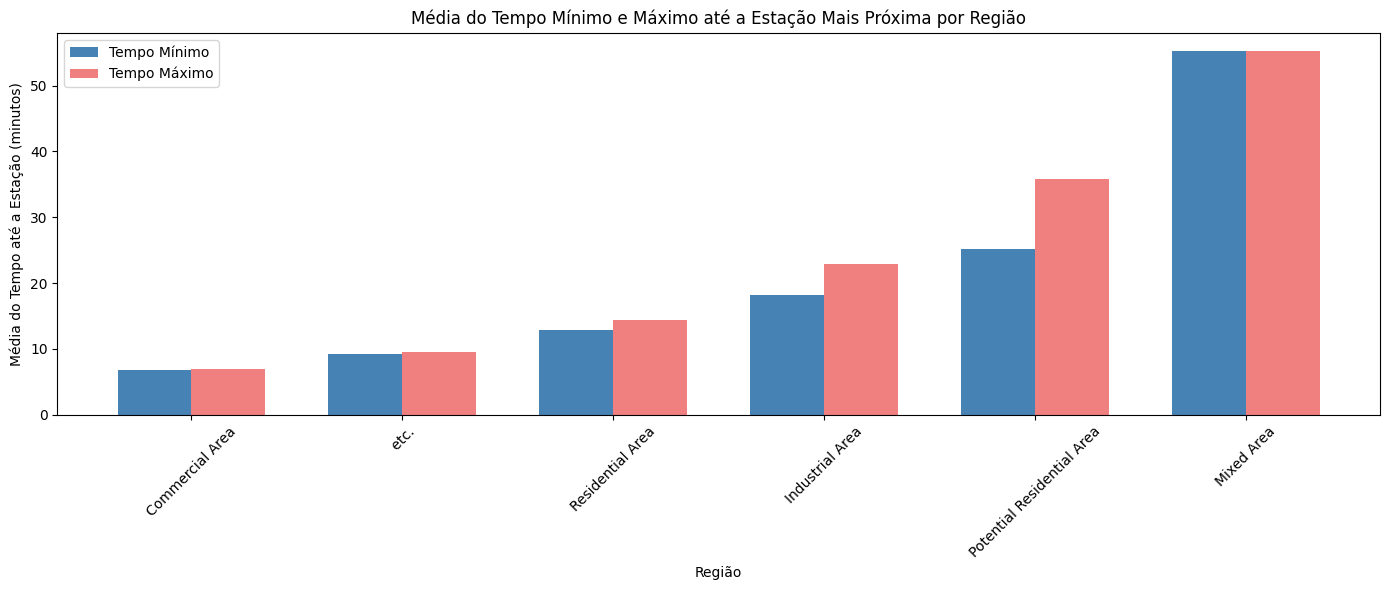

In [108]:
# gráfico de barras agrupadas para tempos mínimos e máximos até a estação
avg_time_by_region = df_treino.groupby('Region')[['MinTimeToNearestStation', 'MaxTimeToNearestStation']].mean().sort_values(by='MinTimeToNearestStation')
plt.figure(figsize=(14, 6))
width = 0.35  

positions = range(len(avg_time_by_region))
# plotando o gráfico
plt.bar(positions, avg_time_by_region['MinTimeToNearestStation'], width=width, color='steelblue', label='Tempo Mínimo')
plt.bar([p + width for p in positions], avg_time_by_region['MaxTimeToNearestStation'], width=width, color='lightcoral', label='Tempo Máximo')


plt.xticks([p + width / 2 for p in positions], avg_time_by_region.index, rotation=45)
plt.title("Média do Tempo Mínimo e Máximo até a Estação Mais Próxima por Região")
plt.xlabel("Região")
plt.ylabel("Média do Tempo até a Estação (minutos)")
plt.legend()
plt.tight_layout()
plt.show()


Áreas que tem tempo médio mínimo mais baixo podem indicar um fácil acesso ao transporte público, o que é bom para os moradores e pode valorizar a propriedade. Vamos analisar a correlação entre os tempos médios e o preço dos imóveis.

Correlação entre o tempo médio até a estação e o preço médio das propriedades:
                          MinTimeToNearestStation  MaxTimeToNearestStation  \
MinTimeToNearestStation                 1.000000                 0.974594   
MaxTimeToNearestStation                 0.974594                 1.000000   
AvgTradePrice                          -0.438413                -0.414183   

                         AvgTradePrice  
MinTimeToNearestStation      -0.438413  
MaxTimeToNearestStation      -0.414183  
AvgTradePrice                 1.000000  


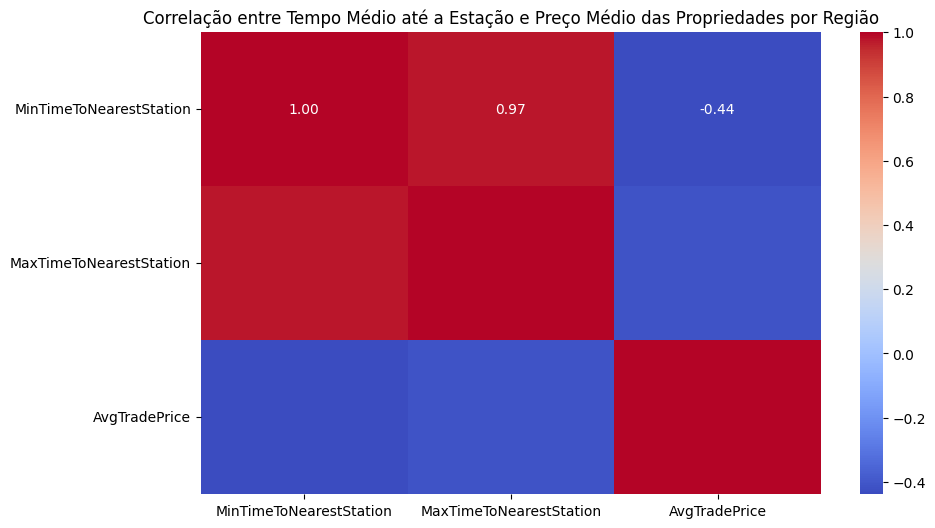

In [109]:
avg_station_time_price = df_treino.groupby('Region').agg({
    'MinTimeToNearestStation': 'mean',
    'MaxTimeToNearestStation': 'mean',
    'TradePrice': 'mean'
}).rename(columns={'TradePrice': 'AvgTradePrice'})

# Cálculo da correlação entre tempo médio e preço médio das propriedades
correlation = avg_station_time_price[['MinTimeToNearestStation', 'MaxTimeToNearestStation', 'AvgTradePrice']].corr()
print("Correlação entre o tempo médio até a estação e o preço médio das propriedades:\n", correlation)

# Visualização dos resultados
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre Tempo Médio até a Estação e Preço Médio das Propriedades por Região")
plt.show()

A correlação é negativa entre os tempos Mínimo e Máximo e o preço médio. Isso sugere que:
1. Propriedades mais próximas ao transporte público (menor tempo para a estação) tendem a ter um preço médio mais alto.
2. A correlação negativa moderada (-0.43 e -0.41) implica que a proximidade ao transporte tem um impacto considerável, mas não absoluto, no valor das propriedades, isto é, maior demanda por locais bem localizados

### 5. Qual é a média e a mediana do preço de venda (TradePrice) para cada trimestre (Quarter) ao longo dos anos?

In [110]:
# avg_median_trade_price = df_treino.groupby(['Year', 'Quarter'])['TradePrice'].agg(['mean', 'median']).reset_index()
# avg_median_trade_price.columns = ['Year', 'Quarter', 'AvgTradePrice', 'MedianTradePrice']

# # Exibindo os primeiros resultados
# print(avg_median_trade_price.head())

# # Plotando a média e a mediana do preço de venda por trimestre ao longo dos anos
# plt.figure(figsize=(14, 8))
# sns.lineplot(data=avg_median_trade_price, x='Year', y='AvgTradePrice', hue='Quarter', marker='o', label="Average")
# sns.lineplot(data=avg_median_trade_price, x='Year', y='MedianTradePrice', hue='Quarter', linestyle="--", marker='o', label="Median")
# plt.title('Média e Mediana do Preço por Trimestre ao Longo dos Anos')
# plt.xlabel('Ano')
# plt.ylabel('Preço de Venda')
# plt.legend(title="Quarter")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


Após o anos de 2008, os preços do imóveis caíram dado a crise global, regulações de construções e a situação demográfica no Japão. A população do Japõ está diminuindo vertiginosamente. A estimativa que o Japão diminua um terço em 50 anos. Em 2023 a população do país era de 124,6 milhões.

### 6. Qual a média de preços para os tipo de formato do imóvel? 

                 LandShape        TradePrice
0         Flag-shaped etc.   45830006.190992
1         Irregular Shaped   151023526.65495
2             Other Shaped   31348499.439181
3       Rectangular Shaped   77915636.861644
4  Semi-rectangular Shaped   85258771.511486
5              Semi-shaped  138161476.397956
6       Semi-square Shaped   80616966.757493
7  Semi-trapezoidal Shaped  102732830.349908
8            Square Shaped   77026571.668064
9       Trapezoidal Shaped   96784452.773613


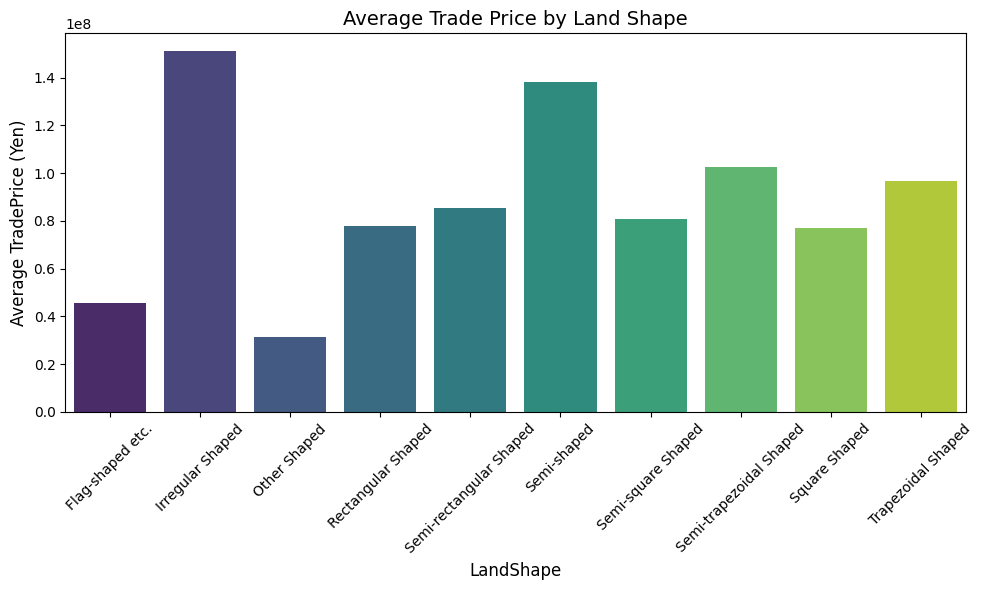

In [111]:
# LandShape e calcular a média do TradePrice
landshape_avg_price = df_treino.groupby('LandShape')['TradePrice'].mean().reset_index()
print(landshape_avg_price)

plt.figure(figsize=(10,6))
sns.barplot(x='LandShape', y='TradePrice', data=landshape_avg_price, palette='viridis')
plt.xlabel('LandShape', fontsize=12)
plt.ylabel('Average TradePrice (Yen)', fontsize=12)
plt.title('Average Trade Price by Land Shape', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Os imóveis com formato irregular, semi-shaped e semi-trapezoidal shape são os mais caros em média. Contudo, não estou convecido que o formato traga alguma diferença exorbitante no valor do preço.

## Modelagem

Nosso objetivo é criar um modelo de previsão para variável *TradePrice*. A priori, esse é um modelo clássico de regressão. Mas acredito que como um cientista de dados, seria interessante testar outros modelos. Primeiro vamos analisar quais variáveis podem entrar no modelo e quais devem ser retiradas

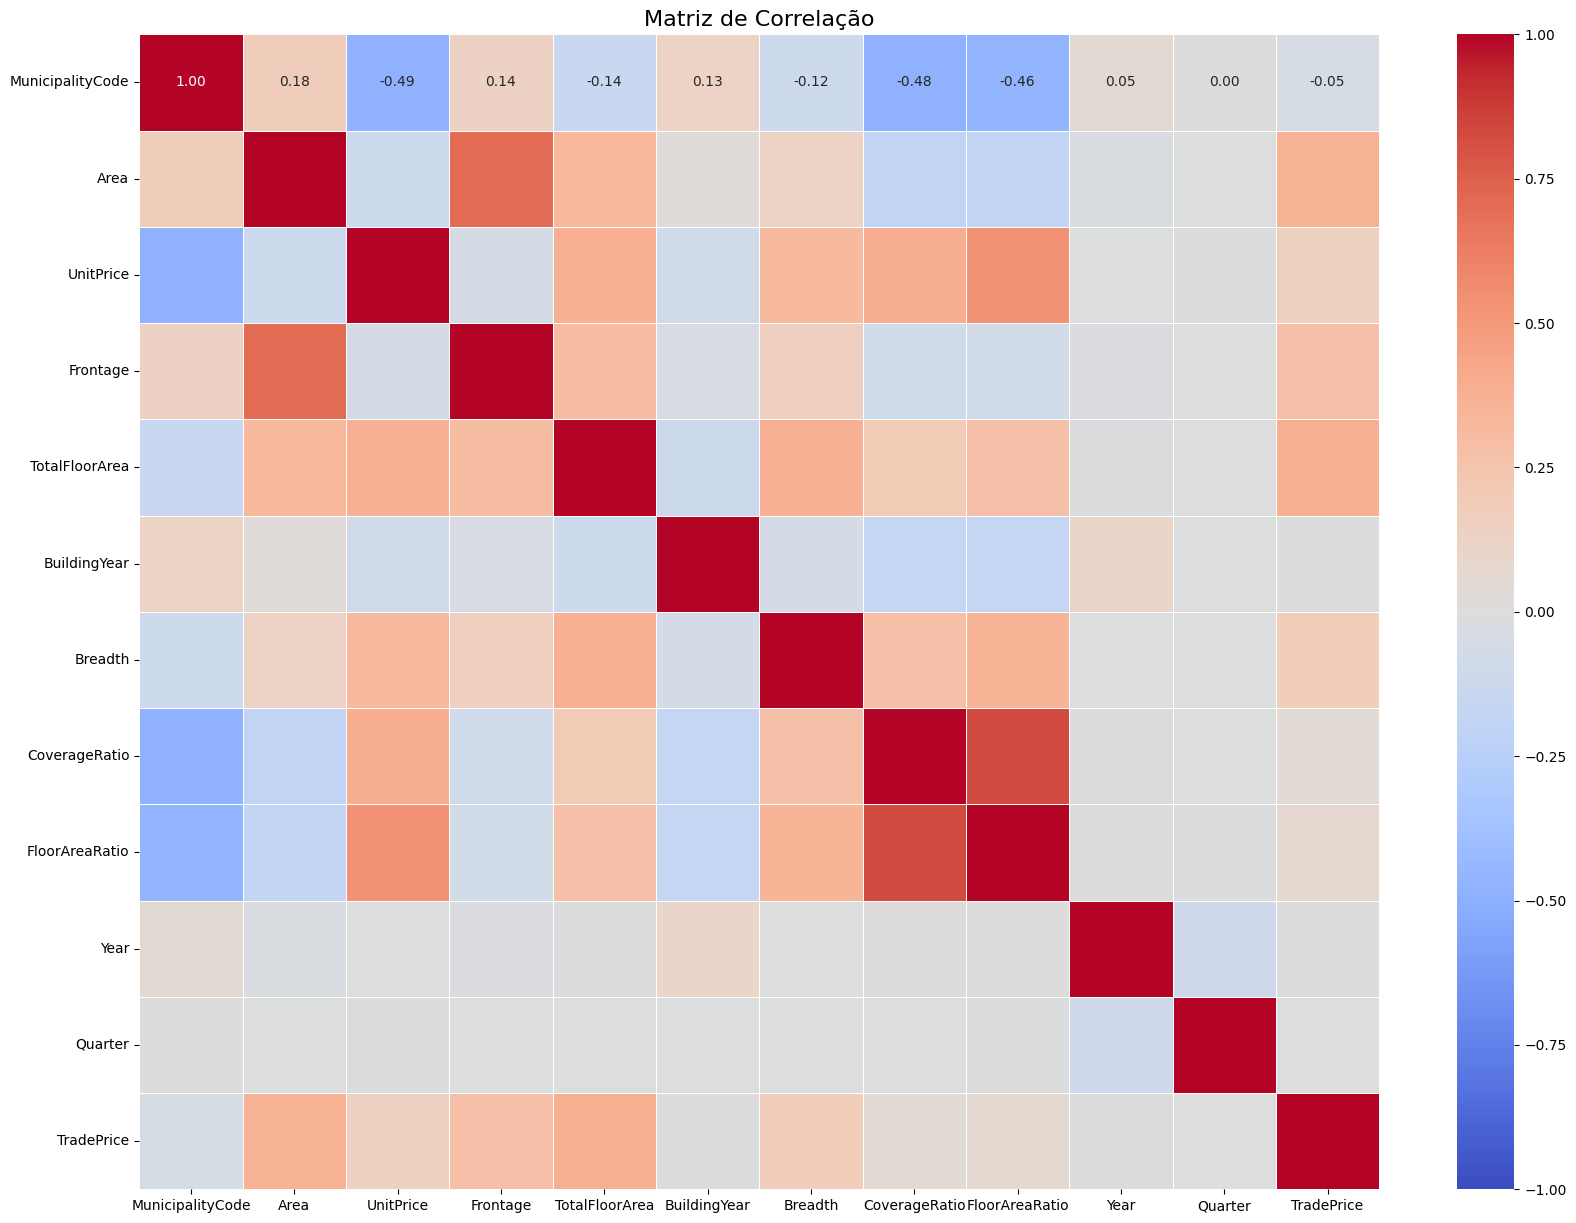

In [112]:

# Selecionando apenas colunas numéricas
df_numeric = df_treino.select_dtypes(include=['number'])

# Calculando a matriz de correlação
correlation_matrix = df_numeric.corr()

# Plotando a matriz de correlação com um mapa de calor
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlação', fontsize=16)
plt.show()


In [113]:
df2.columns

Index(['Type', 'Region', 'MunicipalityCode', 'Municipality', 'DistrictName',
       'NearestStation', 'TimeToNearestStation', 'MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'FloorPlan', 'Area', 'UnitPrice',
       'LandShape', 'Frontage', 'TotalFloorArea', 'BuildingYear', 'Structure',
       'Use', 'Purpose', 'Direction', 'Classification', 'Breadth',
       'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year',
       'Quarter', 'Renovation', 'Remarks', 'TradePrice', 'Purpose_Category'],
      dtype='object')

### Data Preparation

In [114]:
df3 = df2.copy()

In [115]:
df3.isnull().sum()

Type                       0
Region                     0
MunicipalityCode           0
Municipality               0
DistrictName               0
NearestStation             0
TimeToNearestStation       0
MinTimeToNearestStation    0
MaxTimeToNearestStation    0
FloorPlan                  0
Area                       0
UnitPrice                  0
LandShape                  0
Frontage                   0
TotalFloorArea             0
BuildingYear               0
Structure                  0
Use                        0
Purpose                    0
Direction                  0
Classification             0
Breadth                    0
CityPlanning               0
CoverageRatio              0
FloorAreaRatio             0
Period                     0
Year                       0
Quarter                    0
Renovation                 0
Remarks                    0
TradePrice                 0
Purpose_Category           0
dtype: int64

### Feature Selection

Vou tirar algumas variaveis que não considero útil ao modelo além de excluir aquelas que são redundantes, por exemplo:

 - `MunicipalityCode`, `DistrictName` (vou manter `Municipality`)
 - `Remarks`
 - `Period`, `Quarter` (vou manter Year, pois é a "melhor" correlacionada com TradePrice)
 - `Direction` (tirar para evitar redundância)
 - `Breadth` (relacionada com Area)
 - `NearestStation` (se não houver um padrão claro que contribua para o modelo)
 - `Purpose`, `Type`, `Use`, `Purpose`, `CityPlanning`, `Classification`

In [116]:
cols_drop = ['MunicipalityCode', 'DistrictName','Remarks', 'Period', 'Quarter',
             'Direction','Breadth', 'NearestStation', 'Purpose', 'Type', 'Use',
             'CityPlanning', 'Classification', 'TimeToNearestStation', 'FloorPlan',
            'Municipality', ]
df3 = df3.drop(cols_drop, axis=1)

In [117]:
df3.columns

Index(['Region', 'MinTimeToNearestStation', 'MaxTimeToNearestStation', 'Area',
       'UnitPrice', 'LandShape', 'Frontage', 'TotalFloorArea', 'BuildingYear',
       'Structure', 'CoverageRatio', 'FloorAreaRatio', 'Year', 'Renovation',
       'TradePrice', 'Purpose_Category'],
      dtype='object')

### Transforming

In [169]:
# Selecionar as colunas numéricas
a = df_treino.select_dtypes(include=['int64', 'float64'])

# Inicializar os escaladores
rs = RobustScaler()
mms = MinMaxScaler()

# RobustScaler para variáveis com outliers
df3['MinTimeToNearestStation'] = rs.fit_transform(df3[['MinTimeToNearestStation']].values)

df3['MaxTimeToNearestStation'] = rs.fit_transform(df3[['MaxTimeToNearestStation']].values)

# MinMaxScaler para variáveis numéricas que podem ser normalizadas entre 0 e 1
df3['Area'] = mms.fit_transform(df3[['Area']].values)

df3['UnitPrice'] = mms.fit_transform(df3[['UnitPrice']].values)

df3['Frontage'] = mms.fit_transform(df3[['Frontage']].values)

df3['TotalFloorArea'] = mms.fit_transform(df3[['TotalFloorArea']].values)

df3['BuildingYear'] = mms.fit_transform(df3[['BuildingYear']].values)

df3['CoverageRatio'] = mms.fit_transform(df3[['CoverageRatio']].values)

df3['FloorAreaRatio'] = mms.fit_transform(df3[['FloorAreaRatio']].values)

df3['Year'] = mms.fit_transform(df3[['Year']].values)

df3['TradePrice'] = rs.fit_transform(df3[['TradePrice']].values)


### Label Encoding

In [170]:
le = LabelEncoder()

df3['Renovation'] = le.fit_transform(df3['Renovation'])

# Usando pd.get_dummies para aplicar o One Hot Encoding na coluna 'Region'
df3 = pd.get_dummies(df3, columns=['Region'], prefix=['Region'], drop_first=False)

df3.head()


KeyError: "None of [Index(['Region'], dtype='object')] are in the [columns]"

In [171]:
df3.dtypes

MinTimeToNearestStation                     float64
MaxTimeToNearestStation                     float64
Area                                        float64
UnitPrice                                   float64
LandShape                            string[python]
Frontage                                    float64
TotalFloorArea                              float64
BuildingYear                                float64
Structure                                    object
CoverageRatio                               float64
FloorAreaRatio                              float64
Year                                        float64
Renovation                                    int64
TradePrice                                  float64
Purpose_Category                             object
Region_ etc.                                   bool
Region_Commercial Area                         bool
Region_Industrial Area                         bool
Region_Mixed Area                              bool
Region_Poten

In [172]:
cols_selected = ['MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'Area', 'UnitPrice',
       'Frontage', 'TotalFloorArea', 'BuildingYear',
       'CoverageRatio', 'FloorAreaRatio', 'Year']

#'Region', 'FloorPlan', 'Municipality', LandShape, 'Structure','Renovation', 'Purpose_Category'

In [173]:
X = df3[cols_selected] 
y = df3['TradePrice']  

# Separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [178]:
# Função para calcular o erro percentual médio
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

# Função para calcular MAE e RMSE
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    # Retorna as métricas como um DataFrame
    return pd.DataFrame({'Model Name': model_name,
                          'MAE': mae,
                          'RMSE': rmse}, index=[0])


## Machine Learning Modelling

In [179]:
# Modelo de Regressão Linear
lr = LinearRegression()

# Treinando o modelo
lr.fit(X_train, y_train)

# Fazendo as previsões
yhat_lr = lr.predict(X_test)

# Avaliar o modelo usando as funções definidas
lr_result = ml_error('Linear Regression', y_test, yhat_lr)

# Exibir os resultados
print(lr_result)


          Model Name       MAE      RMSE
0  Linear Regression  1.709773  8.237358


In [180]:
lrr_result = ml_error('Lasso Regression', y_test, yhat_lrr)
print(lrr_result)

         Model Name           MAE          RMSE
0  Lasso Regression  7.399301e+07  1.704604e+08


In [176]:
# Modelo de Regressão Random Forest
rf = RandomForestRegressor(random_state=42)

# Treinando o modelo
rf.fit(X_train, y_train)

# Fazendo as previsões
yhat_rf = rf.predict(X_test)

# Avaliar o modelo Random Forest
rf_result = ml_error('Random Forest', y_test, yhat_rf)

# Exibir os resultados
print(rf_result)


      Model Name       MAE  MAPE      RMSE
0  Random Forest  0.545524   inf  7.598877


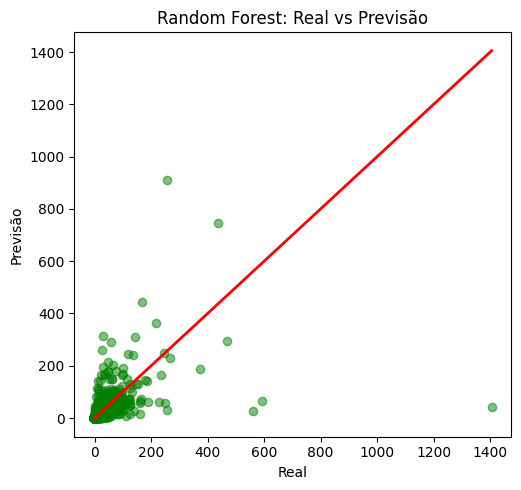

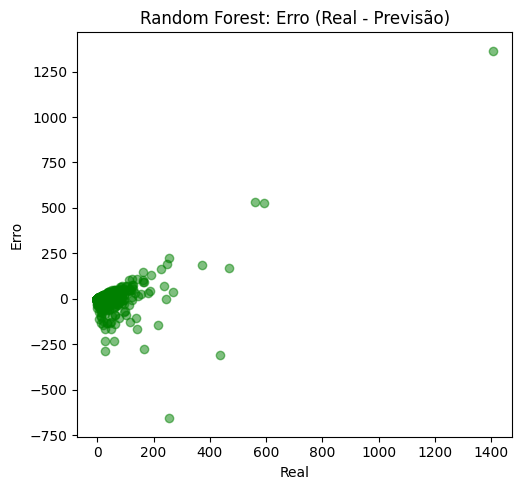

In [186]:
RandomForest = RandomForestRegressor(n_estimators=5, random_state=42)  

# Treinando os modelos
RandomForest.fit(X_train, y_train)  # Treinamento do modelo Random Forest

# Realizando previsões
y_train_pred_Lasso = Lasso.predict(X_train)  # Previsões para o conjunto de treinamento
y_test_pred_Lasso = Lasso.predict(X_test)    # Previsões para o conjunto de teste

y_train_pred_rf = RandomForest.predict(X_train)  # Previsões para o conjunto de treinamento
y_test_pred_rf = RandomForest.predict(X_test)    # Previsões para o conjunto de teste

# Gráfico de dispersão - Real vs Previsão (para os dados de teste)
plt.figure(figsize=(15, 5))

# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred_rf, color='green', alpha=0.5)
plt.title('Random Forest: Real vs Previsão')
plt.xlabel('Real')
plt.ylabel('Previsão')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)

plt.tight_layout()
plt.show()

# Gráfico de erro (Real - Previsão)
plt.figure(figsize=(15, 5))


# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test - y_test_pred_rf, color='green', alpha=0.5)
plt.title('Random Forest: Erro (Real - Previsão)')
plt.xlabel('Real')
plt.ylabel('Erro')

plt.tight_layout()
plt.show()


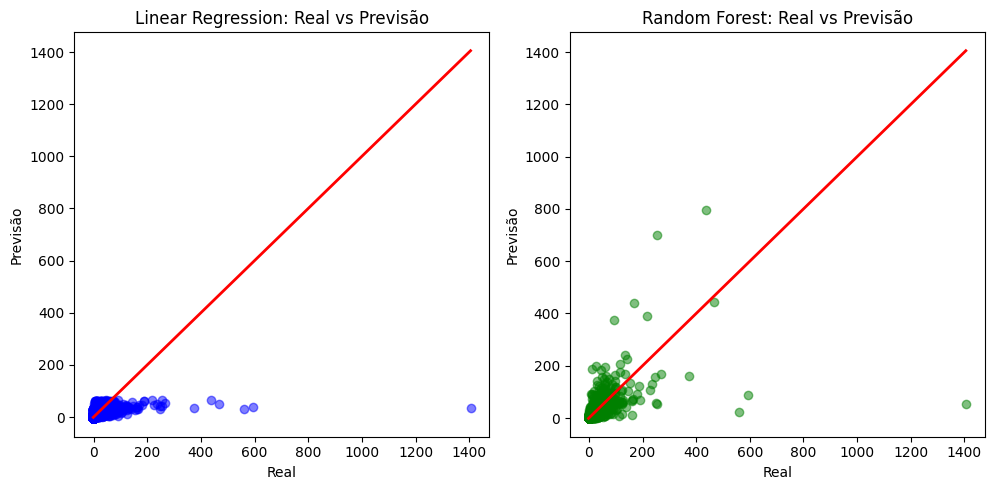

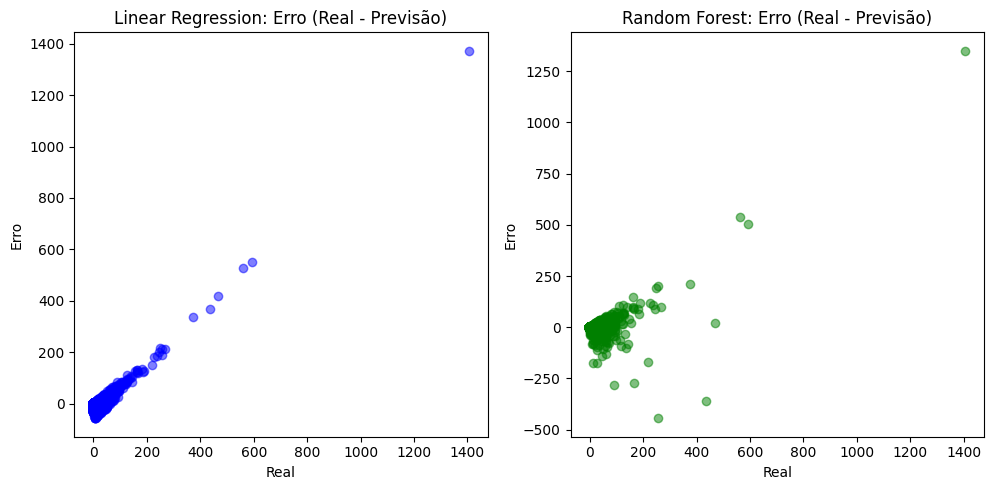

In [188]:
# Instanciando o modelo Linear Regression e Random Forest
linear_reg = LinearRegression()  # Regressão Linear
RandomForest = RandomForestRegressor(n_estimators=100, random_state=42)  # Random Forest

# Treinando os modelos
linear_reg.fit(X_train, y_train)  # Treinamento do modelo Linear Regression
RandomForest.fit(X_train, y_train)  # Treinamento do modelo Random Forest

# Realizando previsões
y_train_pred_lr = linear_reg.predict(X_train)  # Previsões para o conjunto de treinamento
y_test_pred_lr = linear_reg.predict(X_test)    # Previsões para o conjunto de teste

y_train_pred_rf = RandomForest.predict(X_train)  # Previsões para o conjunto de treinamento
y_test_pred_rf = RandomForest.predict(X_test)    # Previsões para o conjunto de teste

# Gráfico de dispersão - Real vs Previsão (para os dados de teste)
plt.figure(figsize=(15, 5))

# Regressão Linear
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred_lr, color='blue', alpha=0.5)
plt.title('Linear Regression: Real vs Previsão')
plt.xlabel('Real')
plt.ylabel('Previsão')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)

# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred_rf, color='green', alpha=0.5)
plt.title('Random Forest: Real vs Previsão')
plt.xlabel('Real')
plt.ylabel('Previsão')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)

plt.tight_layout()
plt.show()

# Gráfico de erro (Real - Previsão)
plt.figure(figsize=(15, 5))

# Regressão Linear
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test - y_test_pred_lr, color='blue', alpha=0.5)
plt.title('Linear Regression: Erro (Real - Previsão)')
plt.xlabel('Real')
plt.ylabel('Erro')

# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test - y_test_pred_rf, color='green', alpha=0.5)
plt.title('Random Forest: Erro (Real - Previsão)')
plt.xlabel('Real')
plt.ylabel('Erro')

plt.tight_layout()
plt.show()
